<a href="https://colab.research.google.com/github/rzunick/MNA-Proyecto-Integrador-Equipo-43/blob/main/Avance_5_v2_Equipo_43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Portada
Instituto Tecnológico de Estudios Superiores de Monterrey

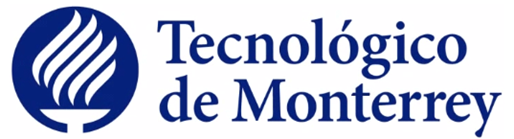

Maestría en Inteligencia Artificial Aplicada (MNA)
Curso: TC5035 Proyecto Integrador

Profesores: Dra. Grettel Barceló Alonso y Dr. Luis Eduardo Falcón

Proyecto: Reconocimiento y Clasificación de Objetos basado en Colores para Detección en Vivo en Cámaras de Seguridad
##Avance 5. Modelo Final

Equipo 43
* Ronald David Zuniga Sanchez - A01686240

#1 - Introducción

En el presente avance del Proyecto Integrador **Reconocimiento y Clasificación de Objetos basado en Colores para Detección en Vivo en Cámaras de Seguridad**, se desarrolla la optimización final del modelo seleccionado para maximizar su rendimiento evaluando la calidad de las predicciones y minimizando los recursos necesarios para las inferencias.

#2 - Importando el Dataset

In [1]:
import torch
import torch.nn as nn
import os
import  numpy as np
import pandas as pd
from torch.utils.data import  Dataset, DataLoader
from  PIL import  Image
from  torchvision.transforms import  ToTensor, Compose, Resize, CenterCrop, Normalize
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import  glob
import requests
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
import shutil
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F

!pip install opencv-python-headless
from torchsummary import summary

from PIL import Image
import cv2
from collections import Counter

from  tqdm import tqdm
from sklearn.metrics import accuracy_score

from  collections import  defaultdict
import json

import time
import random

In [2]:
# URL of the .zip file in the GitHub repository
github_zip_url = "https://github.com/rzunick/MNA-Proyecto-Integrador-Equipo-43/raw/main/cifar_10_color_v4_balanced.zip?download="

# Path to save the downloaded .zip file
zip_file_path = '/content/cifar_10_color_v4.zip'

# Download the .zip file from GitHub
response = requests.get(github_zip_url)
with open(zip_file_path, 'wb') as f:
    f.write(response.content)

# Verify the download
if response.status_code == 200:
    print("File downloaded successfully")
else:
    print("Failed to download file")

File downloaded successfully


In [3]:
#Specify zip file path
zip_file_path = '/content/cifar_10_color_v4.zip'

In [4]:
# Confirmar tipo de archivo es tipo .zip
!file /content/cifar_10_color.zip

/content/cifar_10_color.zip: cannot open `/content/cifar_10_color.zip' (No such file or directory)


In [5]:
from zipfile import ZipFile

# Specify the directory where you want to extract the files
extract_to_directory = '/content'

# Create a ZipFile object
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)

In [6]:
# Dataset Path
path = '/content/cifar_10_color_v4'

Label counts: Counter({2: 1600, 6: 1600, 0: 1600, 3: 1600, 4: 1600, 1: 1600, 5: 1600, 7: 1600})


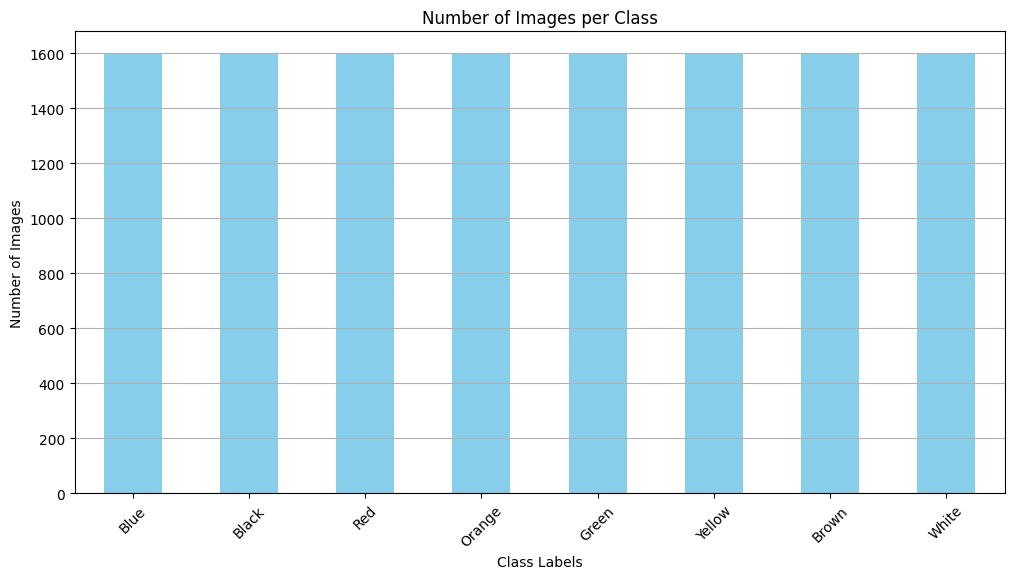

In [7]:
# Configuration 4: 8 labels
labels = ["Red","Yellow","Blue","Orange","Green","Brown","Black","White"]

def decode_label(index):
    return  labels[index]

def encode_label_from_path(path):
    for index,value in enumerate(labels):
        if value in path:
            return  index

# Get image list
image_list = glob.glob(os.path.join(path, '**', '*.*'), recursive=True)
class_list = [encode_label_from_path(item) for item in image_list]

# Count the number of images per class
from collections import Counter
label_counts = Counter(class_list)
print("Label counts:", label_counts)

# Convert the counter to a pandas DataFrame
label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count'])
label_df.index = [labels[idx] for idx in label_df.index]

# Plotting the bar chart
plt.figure(figsize=(12, 6))
label_df['count'].plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()

## Dataset RGB Values Normalization

70 Training / 15 Validation / 15 Test

In [8]:
# Train and Test subsets
x_train, x_temp, y_train, y_temp = train_test_split(image_list, class_list, train_size= 0.7 , stratify=class_list , shuffle=True, random_state=42)

# Dividing Training dataset into Train and Validation subsets
# Since x_temp and y_temp are 30% of the original, splitting them in half gives each 15% of the original dataset.
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, shuffle=True, random_state=42)

In [9]:
def calculate_rgb_stats(image_list):
    all_pixels = np.vstack([np.array(Image.open(img_path).convert('RGB')).reshape(-1, 3) for img_path in image_list])
    mean_rgb = np.mean(all_pixels, axis=0)
    std_dev_rgb = np.std(all_pixels, axis=0)
    return mean_rgb, std_dev_rgb

# Calculate statistics only on training data to avoid data leakage
mean_rgb, std_dev_rgb = calculate_rgb_stats(x_train)

In [10]:
print("Mean (Average) RGB Values: ", mean_rgb)
print("Standard Deviation RGB Values: ", std_dev_rgb)

Mean (Average) RGB Values:  [124.75003924 123.10938383 114.89393648]
Standard Deviation RGB Values:  [63.66785235 62.47050596 67.81292227]


## Loading the Dataset

In [11]:
class ColorDataset_RGB(Dataset):
    def __init__(self, image_list, class_list, mean_rgb, std_dev_rgb):
        self.image_list = image_list
        self.class_list = class_list
        self.mean_rgb = mean_rgb
        self.std_dev_rgb = std_dev_rgb
        self.data_len = len(self.image_list)

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        image_path = self.image_list[index]
        image = Image.open(image_path).convert('RGB')
        image = ToTensor()(image)  # Convert image to tensor
        image = Normalize(mean=self.mean_rgb/255.0, std=self.std_dev_rgb/255.0)(image)
        return image, self.class_list[index]

In [12]:
train_dataset_rgb = ColorDataset_RGB(x_train, y_train, mean_rgb, std_dev_rgb)
train_data_loader = DataLoader(train_dataset_rgb, batch_size=32)

val_dataset_rgb = ColorDataset_RGB(x_val, y_val, mean_rgb, std_dev_rgb)
val_data_loader = DataLoader(val_dataset_rgb, batch_size=32)

test_dataset_rgb = ColorDataset_RGB(x_test, y_test, mean_rgb, std_dev_rgb)
test_data_loader = DataLoader(test_dataset_rgb, batch_size=32)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


#3 - Exploración de Modelos Alternativos


## Modelo Base - Twin Network Structure

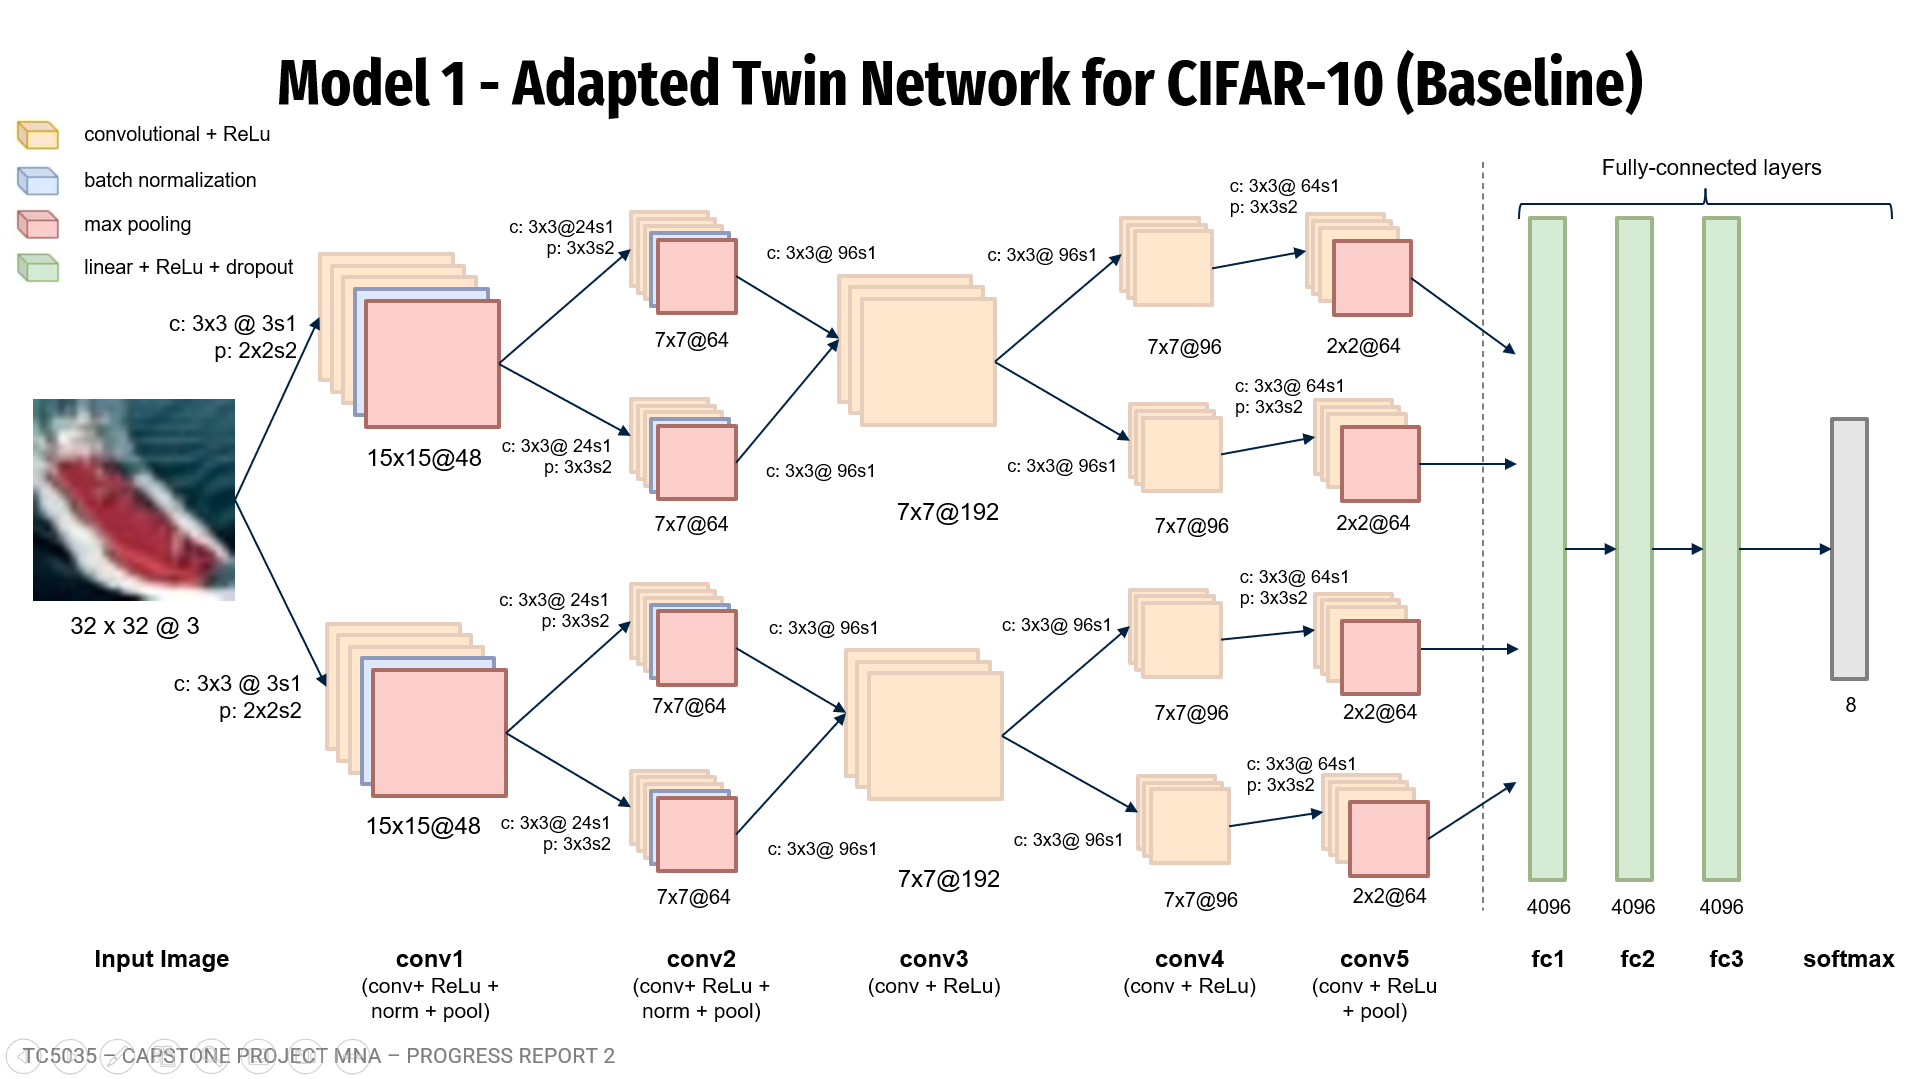

In [14]:
#Define Model
class ColorModel1(nn.Module):
    def __init__(self):
        super(ColorModel1, self).__init__()

        self.top_conv1 = nn.Sequential(
            nn.Conv2d(3,48, kernel_size=(3,3) , stride=(1,1)), # smaller kernel size and stride
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2 , stride=2) # smaller pooling size
        )

        # first top convolution layer    after split
        self.top_top_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.top_bot_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )


        #  need a concat

        # after concat
        self.top_conv3 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(128, 192, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        # fourth top convolution layer
        # split feature map by half
        self.top_top_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        self.top_bot_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )


        # fifth top convolution layer
        self.top_top_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.top_bot_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

#        # ===============================  bottom ================================


#         # first bottom convolution layer
        self.bottom_conv1 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(3, 48, kernel_size=(3,3), stride=(1,1), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        # first top convolution layer    after split
        self.bottom_top_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.bottom_bot_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )


        #  need a concat

        # after concat
        self.bottom_conv3 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(128, 192, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        # fourth top convolution layer
        # split feature map by half
        self.bottom_top_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        self.bottom_bot_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )


        # fifth top convolution layer
        self.bottom_top_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.bottom_bot_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully-connected layer
        self.classifier = nn.Sequential(
            nn.Linear(1024, 4096), # Adjusted for output size
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(4096, 8)
        )

    def forward(self,x):

        # Top Path

        #print(x.shape)
        x_top = self.top_conv1(x)
        #print(x_top.shape)

        x_top_conv = torch.split(x_top, 24, 1)

        x_top_top_conv2 = self.top_top_conv2(x_top_conv[0])
        x_top_bot_conv2 = self.top_bot_conv2(x_top_conv[1])

        x_top_cat1 = torch.cat([x_top_top_conv2,x_top_bot_conv2],1)

        x_top_conv3 = self.top_conv3(x_top_cat1)

        x_top_conv3 = torch.split(x_top_conv3, 96, 1)

        x_top_top_conv4 = self.top_top_conv4(x_top_conv3[0])
        x_top_bot_conv4 = self.top_bot_conv4(x_top_conv3[1])

        x_top_top_conv5 = self.top_top_conv5(x_top_top_conv4)
        x_top_bot_conv5 = self.top_bot_conv5(x_top_bot_conv4)

        # Bottom Path
        x_bottom = self.bottom_conv1(x)

        x_bottom_conv = torch.split(x_bottom, 24, 1)

        x_bottom_top_conv2 = self.bottom_top_conv2(x_bottom_conv[0])
        x_bottom_bot_conv2 = self.bottom_bot_conv2(x_bottom_conv[1])

        x_bottom_cat1 = torch.cat([x_bottom_top_conv2,x_bottom_bot_conv2],1)

        x_bottom_conv3 = self.bottom_conv3(x_bottom_cat1)

        x_bottom_conv3 = torch.split(x_bottom_conv3, 96, 1)

        x_bottom_top_conv4 = self.bottom_top_conv4(x_bottom_conv3[0])
        x_bottom_bot_conv4 = self.bottom_bot_conv4(x_bottom_conv3[1])

        x_bottom_top_conv5 = self.bottom_top_conv5(x_bottom_top_conv4)
        x_bottom_bot_conv5 = self.bottom_bot_conv5(x_bottom_bot_conv4)

        # Concatenate
        x_cat = torch.cat([x_top_top_conv5,x_top_bot_conv5,x_bottom_top_conv5,x_bottom_bot_conv5],1)

        # Print shape before flattening
        #print("x_cat shape before flattening:", x_cat.shape)

        flatten = x_cat.view(x_cat.size(0), -1)
        #print("flatten shape:", flatten.shape)

        output = self.classifier(flatten)

        #output = F.softmax(output)


        return output

In [15]:
class Logger(object):
    def __init__(self, log_dir, name, chkpt_interval):
        super(Logger,self).__init__()
        self.chkpt_interval = chkpt_interval
        self.log_dir = log_dir
        self.name = name
        os.makedirs(os.path.join(log_dir, name), exist_ok= True)
        self.log_path = os.path.join(log_dir, name, 'logs.json')
        self.model_path = os.path.join(log_dir, name, 'model.pt')
        self.logs = defaultdict(list)
        self.logs['epoch'] = 0

    def log(self, key, value ):
        if isinstance(value, dict):
            for k,v in value.items():
                self.log(f'{key}.{k}',v)
        else:
            self.logs[key].append(value)

    def checkpoint(self, model):
        if (self.logs['epoch'] + 1 ) % self.chkpt_interval == 0:
            self.save(model)
        self.logs['epoch'] +=1

    def save(self, model):
        print("Saving Model...")
        with open(self.log_path, 'w') as f:
            json.dump(self.logs, f, sort_keys=True, indent=4)
        epch = self.logs['epoch'] + 1
        torch.save(model.state_dict(), os.path.join(self.log_dir, self.name, f'model_{epch}.pt'))

In [16]:
# Save Model
Model_Path = '/content/models/model1'
logger = Logger(Model_Path, "model1_baseline", 1)

In [17]:
model = ColorModel1()
model.cuda()
opt = torch.optim.SGD(model.parameters(), momentum=0.9, lr = 0.001 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=20,min_lr=1e-08,factor=0.1,verbose=True)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [18]:
# Print the summary of the model
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 30, 30]           1,344
              ReLU-2           [-1, 48, 30, 30]               0
       BatchNorm2d-3           [-1, 48, 30, 30]              96
         MaxPool2d-4           [-1, 48, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]          13,888
              ReLU-6           [-1, 64, 15, 15]               0
       BatchNorm2d-7           [-1, 64, 15, 15]             128
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Conv2d-9           [-1, 64, 15, 15]          13,888
             ReLU-10           [-1, 64, 15, 15]               0
      BatchNorm2d-11           [-1, 64, 15, 15]             128
        MaxPool2d-12             [-1, 64, 7, 7]               0
           Conv2d-13            [-1, 192, 7, 7]         221,376
             ReLU-14            [-1, 19

After Training Loop: The test dataset evaluation is performed after the entire training process is complete. This will give you an overall final assessment of how well your model is expected to perform on unseen data.

Test Phase Details: The model is set to evaluation mode (model.eval()), ensuring that operations like dropout or batch normalization are adjusted for testing rather than training.

Metrics Logging: The final test loss and accuracy are logged to provide insights into the model's performance.

In [19]:
# Training Loop
epochs = 60
for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0
    batch_ = 0
    total_correct = 0  # For accuracy calculation
    total_samples = 0  # For accuracy calculation

    for X, y in tqdm(train_data_loader, unit="batch", desc=f"Train | Epoch {epoch}"):
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        loss_value = loss_fn(pred, y)
        loss_value.backward()
        opt.step()
        opt.zero_grad()

        # Calculate the loss
        running_loss += loss_value.item()

        # Calculate accuracy
        pred_class = pred.argmax(dim=1)
        total_correct += (pred_class == y).sum().item()
        total_samples += y.size(0)

        batch_ += 1

    train_loss = running_loss / batch_
    train_accuracy = (total_correct / total_samples) * 100  # Calculate training accuracy percentage
    logger.log('train_loss', train_loss)
    logger.log('train_acc', train_accuracy)

    # Validation Phase
    model.eval()
    val_running_loss = 0
    val_batch = 0
    correct = 0
    for X, y in tqdm(val_data_loader, unit="batch", desc=f"Val | Epoch {epoch}"):
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        loss_value = loss_fn(pred, y)
        val_running_loss += loss_value.item()
        pred_class = pred.argmax(dim=1)
        correct += (pred_class == y).float().sum().item()
        val_batch += 1
    val_loss = val_running_loss / val_batch
    val_accuracy = correct / (val_batch * 32) * 100  # Assuming the batch size is constant
    logger.log('val_loss', val_loss)
    logger.log('val_acc', val_accuracy)

    # Print the validation loss and accuracy
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Update learning rate scheduler if needed based on validation loss
    lr_scheduler.step(val_loss)

    # Checkpoint the model (optional, based on your checkpointing strategy)
    logger.checkpoint(model)

# Test Evaluation at the end of training
model.eval()
test_running_loss = 0
test_batch = 0
test_correct = 0
for X, y in tqdm(test_data_loader, unit="batch", desc="Test Evaluation"):
    X, y = X.to('cuda'), y.to('cuda')
    pred = model(X)
    loss_value = loss_fn(pred, y)
    test_running_loss += loss_value.item()
    pred_class = pred.argmax(dim=1)
    test_correct += (pred_class == y).float().sum().item()
    test_batch += 1
test_loss = test_running_loss / test_batch
test_accuracy = test_correct / (test_batch * 32) * 100  # Assuming the batch size is constant
logger.log('test_loss', test_loss)
logger.log('test_acc', test_accuracy)

# Print Test Loss and Test Accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Train | Epoch 0:   0%|          | 0/280 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Train | Epoch 0: 100%|██████████| 280/280 [00:09<00:00, 29.94batch/s]
Val | Epoch 0: 100%|██████████| 60/60 [00:01<00:00, 46.54batch/s]


Validation Loss: 2.0578, Validation Accuracy: 29.58%
Saving Model...


Train | Epoch 1: 100%|██████████| 280/280 [00:08<00:00, 33.98batch/s]
Val | Epoch 1: 100%|██████████| 60/60 [00:01<00:00, 44.57batch/s]


Validation Loss: 1.6848, Validation Accuracy: 35.73%
Saving Model...


Train | Epoch 2: 100%|██████████| 280/280 [00:08<00:00, 34.76batch/s]
Val | Epoch 2: 100%|██████████| 60/60 [00:01<00:00, 49.16batch/s]


Validation Loss: 1.4919, Validation Accuracy: 43.49%
Saving Model...


Train | Epoch 3: 100%|██████████| 280/280 [00:08<00:00, 34.54batch/s]
Val | Epoch 3: 100%|██████████| 60/60 [00:01<00:00, 48.79batch/s]


Validation Loss: 1.3990, Validation Accuracy: 49.48%
Saving Model...


Train | Epoch 4: 100%|██████████| 280/280 [00:08<00:00, 34.57batch/s]
Val | Epoch 4: 100%|██████████| 60/60 [00:01<00:00, 48.21batch/s]


Validation Loss: 1.3161, Validation Accuracy: 52.34%
Saving Model...


Train | Epoch 5: 100%|██████████| 280/280 [00:08<00:00, 34.66batch/s]
Val | Epoch 5: 100%|██████████| 60/60 [00:01<00:00, 47.96batch/s]


Validation Loss: 1.2467, Validation Accuracy: 55.68%
Saving Model...


Train | Epoch 6: 100%|██████████| 280/280 [00:08<00:00, 34.50batch/s]
Val | Epoch 6: 100%|██████████| 60/60 [00:01<00:00, 48.12batch/s]


Validation Loss: 1.2073, Validation Accuracy: 58.07%
Saving Model...


Train | Epoch 7: 100%|██████████| 280/280 [00:08<00:00, 34.88batch/s]
Val | Epoch 7: 100%|██████████| 60/60 [00:01<00:00, 48.69batch/s]


Validation Loss: 1.1519, Validation Accuracy: 60.99%
Saving Model...


Train | Epoch 8: 100%|██████████| 280/280 [00:08<00:00, 34.62batch/s]
Val | Epoch 8: 100%|██████████| 60/60 [00:01<00:00, 48.61batch/s]


Validation Loss: 1.1075, Validation Accuracy: 61.67%
Saving Model...


Train | Epoch 9: 100%|██████████| 280/280 [00:08<00:00, 34.51batch/s]
Val | Epoch 9: 100%|██████████| 60/60 [00:01<00:00, 49.18batch/s]


Validation Loss: 1.0789, Validation Accuracy: 63.12%
Saving Model...


Train | Epoch 10: 100%|██████████| 280/280 [00:08<00:00, 34.60batch/s]
Val | Epoch 10: 100%|██████████| 60/60 [00:01<00:00, 48.47batch/s]


Validation Loss: 1.0453, Validation Accuracy: 63.49%
Saving Model...


Train | Epoch 11: 100%|██████████| 280/280 [00:08<00:00, 34.80batch/s]
Val | Epoch 11: 100%|██████████| 60/60 [00:01<00:00, 48.59batch/s]


Validation Loss: 1.0540, Validation Accuracy: 63.44%
Saving Model...


Train | Epoch 12: 100%|██████████| 280/280 [00:07<00:00, 35.08batch/s]
Val | Epoch 12: 100%|██████████| 60/60 [00:01<00:00, 48.78batch/s]


Validation Loss: 1.0339, Validation Accuracy: 63.33%
Saving Model...


Train | Epoch 13: 100%|██████████| 280/280 [00:08<00:00, 34.95batch/s]
Val | Epoch 13: 100%|██████████| 60/60 [00:01<00:00, 49.08batch/s]


Validation Loss: 1.0168, Validation Accuracy: 64.32%
Saving Model...


Train | Epoch 14: 100%|██████████| 280/280 [00:08<00:00, 34.52batch/s]
Val | Epoch 14: 100%|██████████| 60/60 [00:01<00:00, 49.31batch/s]


Validation Loss: 1.0264, Validation Accuracy: 64.79%
Saving Model...


Train | Epoch 15: 100%|██████████| 280/280 [00:08<00:00, 34.73batch/s]
Val | Epoch 15: 100%|██████████| 60/60 [00:01<00:00, 47.96batch/s]


Validation Loss: 1.0207, Validation Accuracy: 65.16%
Saving Model...


Train | Epoch 16: 100%|██████████| 280/280 [00:08<00:00, 34.67batch/s]
Val | Epoch 16: 100%|██████████| 60/60 [00:01<00:00, 47.96batch/s]


Validation Loss: 1.0427, Validation Accuracy: 64.43%
Saving Model...


Train | Epoch 17: 100%|██████████| 280/280 [00:08<00:00, 34.57batch/s]
Val | Epoch 17: 100%|██████████| 60/60 [00:01<00:00, 48.74batch/s]


Validation Loss: 1.0659, Validation Accuracy: 65.16%
Saving Model...


Train | Epoch 18: 100%|██████████| 280/280 [00:08<00:00, 34.69batch/s]
Val | Epoch 18: 100%|██████████| 60/60 [00:01<00:00, 48.04batch/s]


Validation Loss: 1.0488, Validation Accuracy: 65.73%
Saving Model...


Train | Epoch 19: 100%|██████████| 280/280 [00:08<00:00, 34.62batch/s]
Val | Epoch 19: 100%|██████████| 60/60 [00:01<00:00, 48.07batch/s]


Validation Loss: 1.0414, Validation Accuracy: 66.25%
Saving Model...


Train | Epoch 20: 100%|██████████| 280/280 [00:08<00:00, 34.48batch/s]
Val | Epoch 20: 100%|██████████| 60/60 [00:01<00:00, 48.31batch/s]


Validation Loss: 1.1100, Validation Accuracy: 64.64%
Saving Model...


Train | Epoch 21: 100%|██████████| 280/280 [00:08<00:00, 34.39batch/s]
Val | Epoch 21: 100%|██████████| 60/60 [00:01<00:00, 48.43batch/s]


Validation Loss: 1.1267, Validation Accuracy: 64.22%
Saving Model...


Train | Epoch 22: 100%|██████████| 280/280 [00:08<00:00, 34.41batch/s]
Val | Epoch 22: 100%|██████████| 60/60 [00:01<00:00, 48.73batch/s]


Validation Loss: 1.2070, Validation Accuracy: 63.59%
Saving Model...


Train | Epoch 23: 100%|██████████| 280/280 [00:08<00:00, 34.70batch/s]
Val | Epoch 23: 100%|██████████| 60/60 [00:01<00:00, 47.92batch/s]


Validation Loss: 1.3085, Validation Accuracy: 63.12%
Saving Model...


Train | Epoch 24: 100%|██████████| 280/280 [00:08<00:00, 34.64batch/s]
Val | Epoch 24: 100%|██████████| 60/60 [00:01<00:00, 48.31batch/s]


Validation Loss: 1.2966, Validation Accuracy: 63.54%
Saving Model...


Train | Epoch 25: 100%|██████████| 280/280 [00:08<00:00, 34.83batch/s]
Val | Epoch 25: 100%|██████████| 60/60 [00:01<00:00, 48.70batch/s]


Validation Loss: 1.4904, Validation Accuracy: 62.50%
Saving Model...


Train | Epoch 26: 100%|██████████| 280/280 [00:08<00:00, 34.64batch/s]
Val | Epoch 26: 100%|██████████| 60/60 [00:01<00:00, 48.46batch/s]


Validation Loss: 1.6137, Validation Accuracy: 61.15%
Saving Model...


Train | Epoch 27: 100%|██████████| 280/280 [00:08<00:00, 34.32batch/s]
Val | Epoch 27: 100%|██████████| 60/60 [00:01<00:00, 48.47batch/s]


Validation Loss: 1.6096, Validation Accuracy: 61.56%
Saving Model...


Train | Epoch 28: 100%|██████████| 280/280 [00:08<00:00, 34.25batch/s]
Val | Epoch 28: 100%|██████████| 60/60 [00:01<00:00, 48.16batch/s]


Validation Loss: 1.6674, Validation Accuracy: 61.51%
Saving Model...


Train | Epoch 29: 100%|██████████| 280/280 [00:08<00:00, 34.46batch/s]
Val | Epoch 29: 100%|██████████| 60/60 [00:01<00:00, 48.48batch/s]


Validation Loss: 1.5577, Validation Accuracy: 61.72%
Saving Model...


Train | Epoch 30: 100%|██████████| 280/280 [00:08<00:00, 34.60batch/s]
Val | Epoch 30: 100%|██████████| 60/60 [00:01<00:00, 47.92batch/s]


Validation Loss: 1.5751, Validation Accuracy: 61.46%
Saving Model...


Train | Epoch 31: 100%|██████████| 280/280 [00:08<00:00, 34.50batch/s]
Val | Epoch 31: 100%|██████████| 60/60 [00:01<00:00, 48.80batch/s]


Validation Loss: 1.5625, Validation Accuracy: 62.29%
Saving Model...


Train | Epoch 32: 100%|██████████| 280/280 [00:08<00:00, 34.51batch/s]
Val | Epoch 32: 100%|██████████| 60/60 [00:01<00:00, 48.53batch/s]


Validation Loss: 1.7908, Validation Accuracy: 60.52%
Saving Model...


Train | Epoch 33: 100%|██████████| 280/280 [00:08<00:00, 34.46batch/s]
Val | Epoch 33: 100%|██████████| 60/60 [00:01<00:00, 48.04batch/s]


Validation Loss: 1.8963, Validation Accuracy: 59.64%
Saving Model...


Train | Epoch 34: 100%|██████████| 280/280 [00:08<00:00, 34.22batch/s]
Val | Epoch 34: 100%|██████████| 60/60 [00:01<00:00, 47.53batch/s]


Validation Loss: 1.8034, Validation Accuracy: 59.90%
Saving Model...


Train | Epoch 35: 100%|██████████| 280/280 [00:08<00:00, 34.54batch/s]
Val | Epoch 35: 100%|██████████| 60/60 [00:01<00:00, 48.25batch/s]


Validation Loss: 1.5976, Validation Accuracy: 65.31%
Saving Model...


Train | Epoch 36: 100%|██████████| 280/280 [00:08<00:00, 34.47batch/s]
Val | Epoch 36: 100%|██████████| 60/60 [00:01<00:00, 47.81batch/s]


Validation Loss: 1.6397, Validation Accuracy: 65.21%
Saving Model...


Train | Epoch 37: 100%|██████████| 280/280 [00:08<00:00, 34.42batch/s]
Val | Epoch 37: 100%|██████████| 60/60 [00:01<00:00, 47.58batch/s]


Validation Loss: 1.6858, Validation Accuracy: 65.16%
Saving Model...


Train | Epoch 38: 100%|██████████| 280/280 [00:08<00:00, 34.36batch/s]
Val | Epoch 38: 100%|██████████| 60/60 [00:01<00:00, 48.42batch/s]


Validation Loss: 1.7141, Validation Accuracy: 65.10%
Saving Model...


Train | Epoch 39: 100%|██████████| 280/280 [00:08<00:00, 34.53batch/s]
Val | Epoch 39: 100%|██████████| 60/60 [00:01<00:00, 47.74batch/s]


Validation Loss: 1.7622, Validation Accuracy: 65.16%
Saving Model...


Train | Epoch 40: 100%|██████████| 280/280 [00:08<00:00, 34.51batch/s]
Val | Epoch 40: 100%|██████████| 60/60 [00:01<00:00, 47.93batch/s]


Validation Loss: 1.8002, Validation Accuracy: 65.05%
Saving Model...


Train | Epoch 41: 100%|██████████| 280/280 [00:08<00:00, 34.64batch/s]
Val | Epoch 41: 100%|██████████| 60/60 [00:01<00:00, 48.85batch/s]


Validation Loss: 1.8215, Validation Accuracy: 65.26%
Saving Model...


Train | Epoch 42: 100%|██████████| 280/280 [00:08<00:00, 34.62batch/s]
Val | Epoch 42: 100%|██████████| 60/60 [00:01<00:00, 48.79batch/s]


Validation Loss: 1.8486, Validation Accuracy: 65.16%
Saving Model...


Train | Epoch 43: 100%|██████████| 280/280 [00:08<00:00, 34.56batch/s]
Val | Epoch 43: 100%|██████████| 60/60 [00:01<00:00, 48.78batch/s]


Validation Loss: 1.8796, Validation Accuracy: 65.16%
Saving Model...


Train | Epoch 44: 100%|██████████| 280/280 [00:08<00:00, 34.58batch/s]
Val | Epoch 44: 100%|██████████| 60/60 [00:01<00:00, 47.83batch/s]


Validation Loss: 1.9080, Validation Accuracy: 64.79%
Saving Model...


Train | Epoch 45: 100%|██████████| 280/280 [00:08<00:00, 34.68batch/s]
Val | Epoch 45: 100%|██████████| 60/60 [00:01<00:00, 47.89batch/s]


Validation Loss: 1.9286, Validation Accuracy: 65.21%
Saving Model...


Train | Epoch 46: 100%|██████████| 280/280 [00:08<00:00, 34.78batch/s]
Val | Epoch 46: 100%|██████████| 60/60 [00:01<00:00, 48.05batch/s]


Validation Loss: 1.9489, Validation Accuracy: 65.16%
Saving Model...


Train | Epoch 47: 100%|██████████| 280/280 [00:08<00:00, 34.33batch/s]
Val | Epoch 47: 100%|██████████| 60/60 [00:01<00:00, 48.73batch/s]


Validation Loss: 1.9765, Validation Accuracy: 65.00%
Saving Model...


Train | Epoch 48: 100%|██████████| 280/280 [00:08<00:00, 34.73batch/s]
Val | Epoch 48: 100%|██████████| 60/60 [00:01<00:00, 48.83batch/s]


Validation Loss: 2.0042, Validation Accuracy: 64.69%
Saving Model...


Train | Epoch 49: 100%|██████████| 280/280 [00:08<00:00, 34.56batch/s]
Val | Epoch 49: 100%|██████████| 60/60 [00:01<00:00, 48.34batch/s]


Validation Loss: 2.0207, Validation Accuracy: 64.95%
Saving Model...


Train | Epoch 50: 100%|██████████| 280/280 [00:08<00:00, 34.53batch/s]
Val | Epoch 50: 100%|██████████| 60/60 [00:01<00:00, 48.89batch/s]


Validation Loss: 2.0448, Validation Accuracy: 65.00%
Saving Model...


Train | Epoch 51: 100%|██████████| 280/280 [00:08<00:00, 34.45batch/s]
Val | Epoch 51: 100%|██████████| 60/60 [00:01<00:00, 47.57batch/s]


Validation Loss: 2.0579, Validation Accuracy: 64.69%
Saving Model...


Train | Epoch 52: 100%|██████████| 280/280 [00:08<00:00, 34.54batch/s]
Val | Epoch 52: 100%|██████████| 60/60 [00:01<00:00, 48.10batch/s]


Validation Loss: 2.0710, Validation Accuracy: 64.90%
Saving Model...


Train | Epoch 53: 100%|██████████| 280/280 [00:08<00:00, 34.35batch/s]
Val | Epoch 53: 100%|██████████| 60/60 [00:01<00:00, 48.94batch/s]


Validation Loss: 2.0865, Validation Accuracy: 64.79%
Saving Model...


Train | Epoch 54: 100%|██████████| 280/280 [00:08<00:00, 34.63batch/s]
Val | Epoch 54: 100%|██████████| 60/60 [00:01<00:00, 48.04batch/s]


Validation Loss: 2.1092, Validation Accuracy: 64.84%
Saving Model...


Train | Epoch 55: 100%|██████████| 280/280 [00:08<00:00, 34.37batch/s]
Val | Epoch 55: 100%|██████████| 60/60 [00:01<00:00, 48.22batch/s]


Validation Loss: 2.1213, Validation Accuracy: 64.84%
Saving Model...


Train | Epoch 56: 100%|██████████| 280/280 [00:08<00:00, 34.52batch/s]
Val | Epoch 56: 100%|██████████| 60/60 [00:01<00:00, 48.35batch/s]


Validation Loss: 2.1182, Validation Accuracy: 64.95%
Saving Model...


Train | Epoch 57: 100%|██████████| 280/280 [00:08<00:00, 34.80batch/s]
Val | Epoch 57: 100%|██████████| 60/60 [00:01<00:00, 48.55batch/s]


Validation Loss: 2.1189, Validation Accuracy: 65.00%
Saving Model...


Train | Epoch 58: 100%|██████████| 280/280 [00:08<00:00, 34.66batch/s]
Val | Epoch 58: 100%|██████████| 60/60 [00:01<00:00, 48.09batch/s]


Validation Loss: 2.1231, Validation Accuracy: 64.90%
Saving Model...


Train | Epoch 59: 100%|██████████| 280/280 [00:08<00:00, 34.37batch/s]
Val | Epoch 59: 100%|██████████| 60/60 [00:01<00:00, 46.90batch/s]


Validation Loss: 2.1219, Validation Accuracy: 65.16%
Saving Model...


Test Evaluation: 100%|██████████| 60/60 [00:01<00:00, 47.59batch/s]

Test Loss: 2.3270
Test Accuracy: 63.18%


Métricas

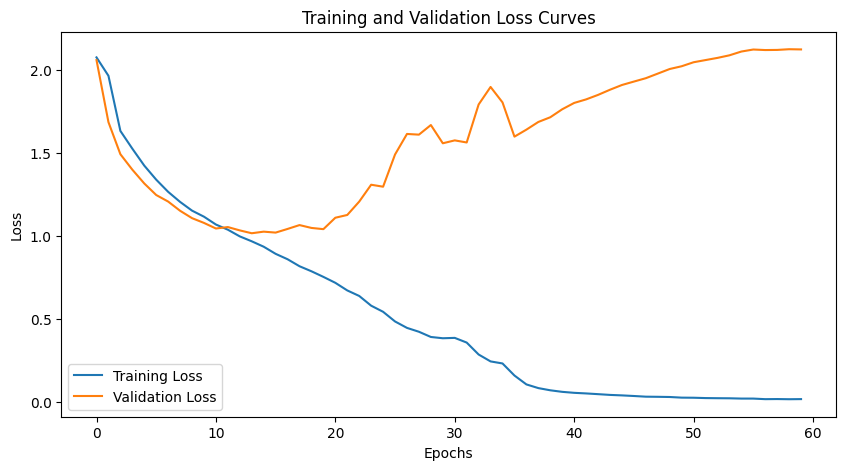

In [20]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

# Example usage
train_losses = logger.logs['train_loss']
val_losses = logger.logs['val_loss']
plot_loss_curves(train_losses, val_losses)

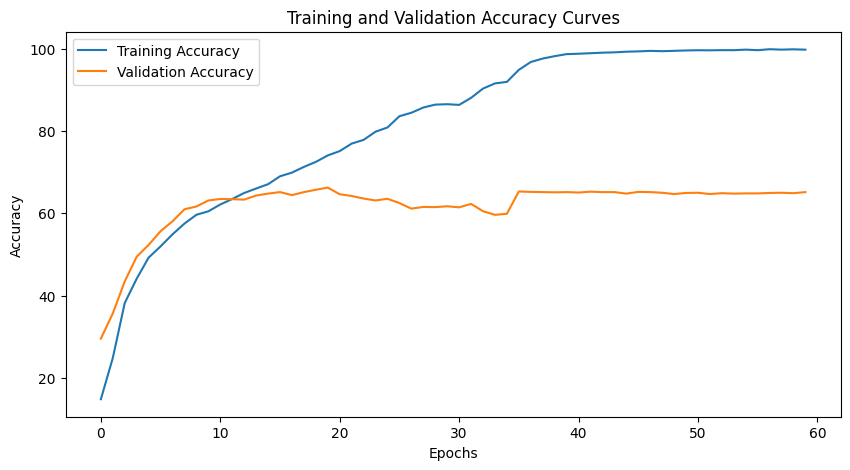

In [21]:

def plot_accuracy_curves(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.show()

# Example usage
train_accuracies = [acc for acc in logger.logs['train_acc']]
val_accuracies = [acc for acc in logger.logs['val_acc']]
plot_accuracy_curves(train_accuracies, val_accuracies)

Test Loss: 2.3270
Test Accuracy: 63.18%


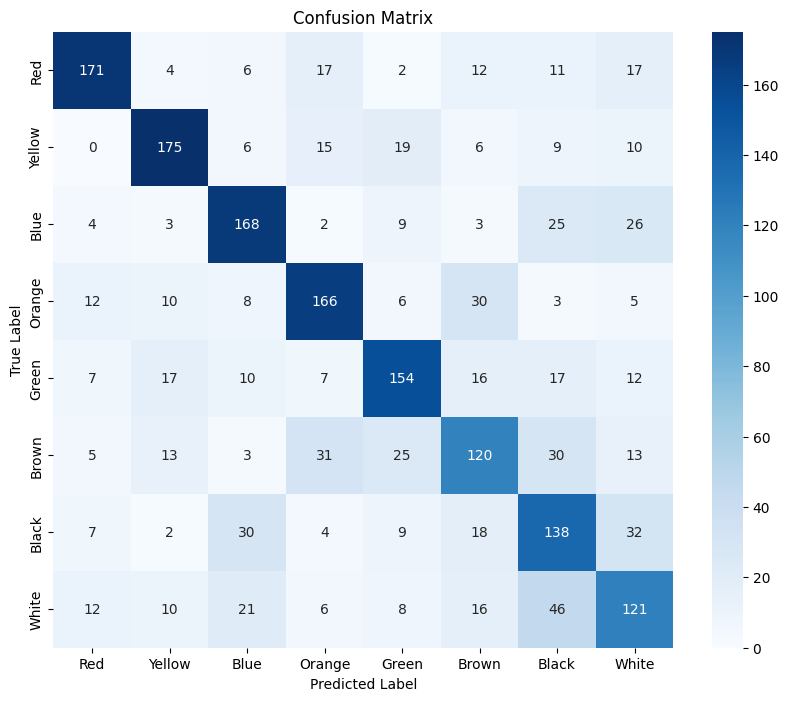

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage (assuming y_test contains true labels)
y_true = y_test  # Directly use y_test
y_pred = []

with torch.no_grad():
    model.eval()
    for X, y in test_data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

# Print Test Loss and Test Accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Plot Confusion Matrix for Test Dataset
plot_confusion_matrix(y_true, y_pred, labels)

Inference Time Model Profiling

In [23]:
# Evaluate inference time
model.eval()
total_inference_time = 0
total_batches = 0

with torch.no_grad():
    for X, y in tqdm(test_data_loader, unit="batch", desc="Test Inference Time Evaluation"):
        X, y = X.to('cuda'), y.to('cuda')

        start_time = time.time()
        pred = model(X)
        end_time = time.time()

        inference_time = (end_time - start_time) * 1000  # Time in milliseconds
        total_inference_time += inference_time
        total_batches += 1

average_inference_time = total_inference_time / total_batches
print(f"Average Inference Time per Batch: {average_inference_time:.3f} ms")

Test Inference Time Evaluation: 100%|██████████| 60/60 [00:01<00:00, 50.47batch/s]

Average Inference Time per Batch: 3.142 ms



## Modelo 2 - Single Network

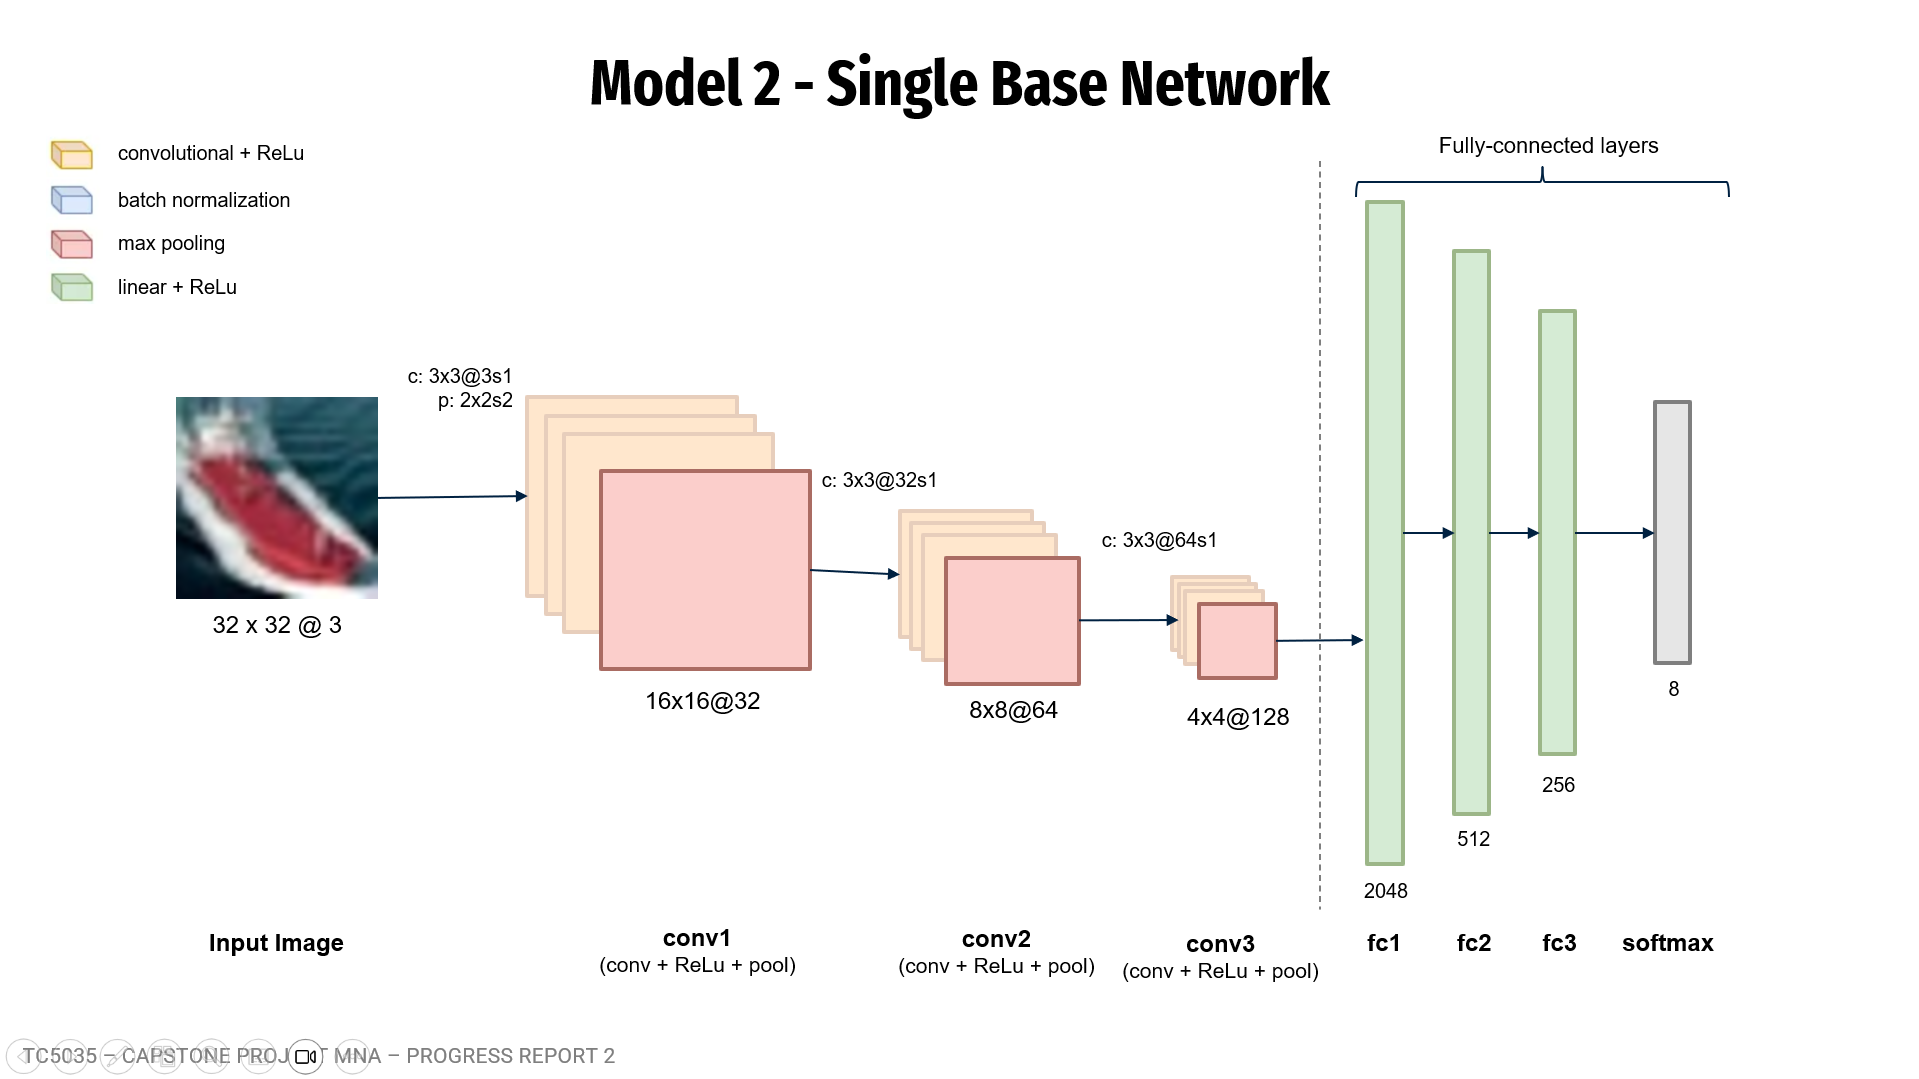

In [24]:
class ColorModel2(nn.Module):
    def __init__(self):
        super(ColorModel2, self).__init__()

        # Convolutional Layer 1: Input channels = 3 (RGB), Output channels = 32
        # Kernel size = 3x3, Padding = 1 (to maintain size)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling over a (2, 2) window

        # Convolutional Layer 2: Increasing the depth to 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Convolutional Layer 3: Increasing the depth to 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully Connected Layers
        # Flattening the output from the convolutional layers to feed into the fully connected layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Image size is 32x32 initially and reduced to 4x4 after three poolings
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)  # Output layer: 8 classes for colors

    def forward(self, x):
        # Applying convolution + ReLU + pooling in each convolution layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Correct flattening based on the output size of the last pooling layer
        x = x.view(-1, 128 * 4 * 4)  # ensure this matches the size, here 128 * 4 * 4 is based on the assumption the output is 4x4 at the last conv layer

        # Fully connected layers with ReLU activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer
        x = self.fc3(x)
        return x

In [25]:
# Save Model
Model_Path = '/content/models/model2'
logger = Logger(Model_Path, "model2_single_network", 1)

In [26]:
model = ColorModel2()
model.cuda()
opt = torch.optim.SGD(model.parameters(), momentum=0.9, lr = 0.001 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=20,min_lr=1e-08,factor=0.1,verbose=True)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [27]:
# Print the summary of the model
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 512]       1,049,088
            Linear-8                  [-1, 256]         131,328
            Linear-9                    [-1, 8]           2,056
Total params: 1,275,720
Trainable params: 1,275,720
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 4.87
Estimated Total Size (MB): 5.43
---------------------------------------

In [28]:
# Training Loop
epochs = 60
for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0
    batch_ = 0
    total_correct = 0  # For accuracy calculation
    total_samples = 0  # For accuracy calculation

    for X, y in tqdm(train_data_loader, unit="batch", desc=f"Train | Epoch {epoch}"):
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        loss_value = loss_fn(pred, y)
        loss_value.backward()
        opt.step()
        opt.zero_grad()

        # Calculate the loss
        running_loss += loss_value.item()

        # Calculate accuracy
        pred_class = pred.argmax(dim=1)
        total_correct += (pred_class == y).sum().item()
        total_samples += y.size(0)

        batch_ += 1

    train_loss = running_loss / batch_
    train_accuracy = (total_correct / total_samples) * 100  # Calculate training accuracy percentage
    logger.log('train_loss', train_loss)
    logger.log('train_acc', train_accuracy)

    # Validation Phase
    model.eval()
    val_running_loss = 0
    val_batch = 0
    correct = 0
    for X, y in tqdm(val_data_loader, unit="batch", desc=f"Val | Epoch {epoch}"):
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        loss_value = loss_fn(pred, y)
        val_running_loss += loss_value.item()
        pred_class = pred.argmax(dim=1)
        correct += (pred_class == y).float().sum().item()
        val_batch += 1
    val_loss = val_running_loss / val_batch
    val_accuracy = correct / (val_batch * 32) * 100  # Assuming the batch size is constant
    logger.log('val_loss', val_loss)
    logger.log('val_acc', val_accuracy)

    # Print the validation loss and accuracy
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Update learning rate scheduler if needed based on validation loss
    lr_scheduler.step(val_loss)

    # Checkpoint the model (optional, based on your checkpointing strategy)
    logger.checkpoint(model)

# Test Evaluation at the end of training
model.eval()
test_running_loss = 0
test_batch = 0
test_correct = 0
for X, y in tqdm(test_data_loader, unit="batch", desc="Test Evaluation"):
    X, y = X.to('cuda'), y.to('cuda')
    pred = model(X)
    loss_value = loss_fn(pred, y)
    test_running_loss += loss_value.item()
    pred_class = pred.argmax(dim=1)
    test_correct += (pred_class == y).float().sum().item()
    test_batch += 1
test_loss = test_running_loss / test_batch
test_accuracy = test_correct / (test_batch * 32) * 100  # Assuming the batch size is constant
logger.log('test_loss', test_loss)
logger.log('test_acc', test_accuracy)

# Print Test Loss and Test Accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Train | Epoch 0: 100%|██████████| 280/280 [00:05<00:00, 50.59batch/s]
Val | Epoch 0: 100%|██████████| 60/60 [00:01<00:00, 56.47batch/s]


Validation Loss: 2.0735, Validation Accuracy: 17.03%
Saving Model...


Train | Epoch 1: 100%|██████████| 280/280 [00:05<00:00, 51.20batch/s]
Val | Epoch 1: 100%|██████████| 60/60 [00:01<00:00, 56.22batch/s]


Validation Loss: 2.0587, Validation Accuracy: 26.35%
Saving Model...


Train | Epoch 2: 100%|██████████| 280/280 [00:05<00:00, 51.10batch/s]
Val | Epoch 2: 100%|██████████| 60/60 [00:01<00:00, 56.98batch/s]


Validation Loss: 1.9623, Validation Accuracy: 28.49%
Saving Model...


Train | Epoch 3: 100%|██████████| 280/280 [00:05<00:00, 51.62batch/s]
Val | Epoch 3: 100%|██████████| 60/60 [00:01<00:00, 57.31batch/s]


Validation Loss: 1.7348, Validation Accuracy: 33.65%
Saving Model...


Train | Epoch 4: 100%|██████████| 280/280 [00:05<00:00, 51.46batch/s]
Val | Epoch 4: 100%|██████████| 60/60 [00:01<00:00, 56.93batch/s]


Validation Loss: 1.6447, Validation Accuracy: 38.65%
Saving Model...


Train | Epoch 5: 100%|██████████| 280/280 [00:05<00:00, 50.95batch/s]
Val | Epoch 5: 100%|██████████| 60/60 [00:01<00:00, 56.58batch/s]


Validation Loss: 1.6043, Validation Accuracy: 40.16%
Saving Model...


Train | Epoch 6: 100%|██████████| 280/280 [00:05<00:00, 51.37batch/s]
Val | Epoch 6: 100%|██████████| 60/60 [00:01<00:00, 57.24batch/s]


Validation Loss: 1.5747, Validation Accuracy: 42.08%
Saving Model...


Train | Epoch 7: 100%|██████████| 280/280 [00:05<00:00, 51.51batch/s]
Val | Epoch 7: 100%|██████████| 60/60 [00:01<00:00, 56.46batch/s]


Validation Loss: 1.5284, Validation Accuracy: 43.54%
Saving Model...


Train | Epoch 8: 100%|██████████| 280/280 [00:05<00:00, 50.46batch/s]
Val | Epoch 8: 100%|██████████| 60/60 [00:01<00:00, 56.86batch/s]


Validation Loss: 1.4160, Validation Accuracy: 48.54%
Saving Model...


Train | Epoch 9: 100%|██████████| 280/280 [00:05<00:00, 51.32batch/s]
Val | Epoch 9: 100%|██████████| 60/60 [00:01<00:00, 56.58batch/s]


Validation Loss: 1.3487, Validation Accuracy: 51.25%
Saving Model...


Train | Epoch 10: 100%|██████████| 280/280 [00:05<00:00, 51.39batch/s]
Val | Epoch 10: 100%|██████████| 60/60 [00:01<00:00, 56.49batch/s]


Validation Loss: 1.2991, Validation Accuracy: 53.65%
Saving Model...


Train | Epoch 11: 100%|██████████| 280/280 [00:05<00:00, 51.45batch/s]
Val | Epoch 11: 100%|██████████| 60/60 [00:01<00:00, 56.73batch/s]


Validation Loss: 1.2605, Validation Accuracy: 55.31%
Saving Model...


Train | Epoch 12: 100%|██████████| 280/280 [00:05<00:00, 51.21batch/s]
Val | Epoch 12: 100%|██████████| 60/60 [00:01<00:00, 56.32batch/s]


Validation Loss: 1.2335, Validation Accuracy: 56.30%
Saving Model...


Train | Epoch 13: 100%|██████████| 280/280 [00:05<00:00, 51.76batch/s]
Val | Epoch 13: 100%|██████████| 60/60 [00:01<00:00, 57.34batch/s]


Validation Loss: 1.2142, Validation Accuracy: 57.29%
Saving Model...


Train | Epoch 14: 100%|██████████| 280/280 [00:05<00:00, 51.63batch/s]
Val | Epoch 14: 100%|██████████| 60/60 [00:01<00:00, 57.44batch/s]


Validation Loss: 1.1999, Validation Accuracy: 57.19%
Saving Model...


Train | Epoch 15: 100%|██████████| 280/280 [00:05<00:00, 51.36batch/s]
Val | Epoch 15: 100%|██████████| 60/60 [00:01<00:00, 56.15batch/s]


Validation Loss: 1.1889, Validation Accuracy: 57.40%
Saving Model...


Train | Epoch 16: 100%|██████████| 280/280 [00:05<00:00, 51.01batch/s]
Val | Epoch 16: 100%|██████████| 60/60 [00:01<00:00, 56.55batch/s]


Validation Loss: 1.1771, Validation Accuracy: 57.92%
Saving Model...


Train | Epoch 17: 100%|██████████| 280/280 [00:05<00:00, 50.61batch/s]
Val | Epoch 17: 100%|██████████| 60/60 [00:01<00:00, 56.81batch/s]


Validation Loss: 1.1703, Validation Accuracy: 58.13%
Saving Model...


Train | Epoch 18: 100%|██████████| 280/280 [00:05<00:00, 51.33batch/s]
Val | Epoch 18: 100%|██████████| 60/60 [00:01<00:00, 57.06batch/s]


Validation Loss: 1.1622, Validation Accuracy: 58.28%
Saving Model...


Train | Epoch 19: 100%|██████████| 280/280 [00:05<00:00, 51.61batch/s]
Val | Epoch 19: 100%|██████████| 60/60 [00:01<00:00, 57.31batch/s]


Validation Loss: 1.1570, Validation Accuracy: 58.59%
Saving Model...


Train | Epoch 20: 100%|██████████| 280/280 [00:05<00:00, 51.83batch/s]
Val | Epoch 20: 100%|██████████| 60/60 [00:01<00:00, 58.01batch/s]


Validation Loss: 1.1506, Validation Accuracy: 58.70%
Saving Model...


Train | Epoch 21: 100%|██████████| 280/280 [00:05<00:00, 51.41batch/s]
Val | Epoch 21: 100%|██████████| 60/60 [00:01<00:00, 57.36batch/s]


Validation Loss: 1.1441, Validation Accuracy: 59.01%
Saving Model...


Train | Epoch 22: 100%|██████████| 280/280 [00:05<00:00, 51.04batch/s]
Val | Epoch 22: 100%|██████████| 60/60 [00:01<00:00, 57.53batch/s]


Validation Loss: 1.1389, Validation Accuracy: 59.53%
Saving Model...


Train | Epoch 23: 100%|██████████| 280/280 [00:05<00:00, 51.24batch/s]
Val | Epoch 23: 100%|██████████| 60/60 [00:01<00:00, 56.45batch/s]


Validation Loss: 1.1328, Validation Accuracy: 59.53%
Saving Model...


Train | Epoch 24: 100%|██████████| 280/280 [00:05<00:00, 50.85batch/s]
Val | Epoch 24: 100%|██████████| 60/60 [00:01<00:00, 55.78batch/s]


Validation Loss: 1.1259, Validation Accuracy: 59.74%
Saving Model...


Train | Epoch 25: 100%|██████████| 280/280 [00:05<00:00, 51.02batch/s]
Val | Epoch 25: 100%|██████████| 60/60 [00:01<00:00, 56.73batch/s]


Validation Loss: 1.1183, Validation Accuracy: 60.00%
Saving Model...


Train | Epoch 26: 100%|██████████| 280/280 [00:05<00:00, 51.51batch/s]
Val | Epoch 26: 100%|██████████| 60/60 [00:01<00:00, 55.31batch/s]


Validation Loss: 1.1149, Validation Accuracy: 60.36%
Saving Model...


Train | Epoch 27: 100%|██████████| 280/280 [00:05<00:00, 51.01batch/s]
Val | Epoch 27: 100%|██████████| 60/60 [00:01<00:00, 57.56batch/s]


Validation Loss: 1.1121, Validation Accuracy: 60.62%
Saving Model...


Train | Epoch 28: 100%|██████████| 280/280 [00:05<00:00, 50.84batch/s]
Val | Epoch 28: 100%|██████████| 60/60 [00:01<00:00, 57.23batch/s]


Validation Loss: 1.1114, Validation Accuracy: 61.15%
Saving Model...


Train | Epoch 29: 100%|██████████| 280/280 [00:05<00:00, 51.62batch/s]
Val | Epoch 29: 100%|██████████| 60/60 [00:01<00:00, 56.65batch/s]


Validation Loss: 1.1101, Validation Accuracy: 61.72%
Saving Model...


Train | Epoch 30: 100%|██████████| 280/280 [00:05<00:00, 51.07batch/s]
Val | Epoch 30: 100%|██████████| 60/60 [00:01<00:00, 57.10batch/s]


Validation Loss: 1.1107, Validation Accuracy: 61.82%
Saving Model...


Train | Epoch 31: 100%|██████████| 280/280 [00:05<00:00, 51.70batch/s]
Val | Epoch 31: 100%|██████████| 60/60 [00:01<00:00, 57.05batch/s]


Validation Loss: 1.1129, Validation Accuracy: 61.61%
Saving Model...


Train | Epoch 32: 100%|██████████| 280/280 [00:05<00:00, 51.29batch/s]
Val | Epoch 32: 100%|██████████| 60/60 [00:01<00:00, 56.93batch/s]


Validation Loss: 1.1207, Validation Accuracy: 62.19%
Saving Model...


Train | Epoch 33: 100%|██████████| 280/280 [00:05<00:00, 51.46batch/s]
Val | Epoch 33: 100%|██████████| 60/60 [00:01<00:00, 55.92batch/s]


Validation Loss: 1.1276, Validation Accuracy: 61.82%
Saving Model...


Train | Epoch 34: 100%|██████████| 280/280 [00:05<00:00, 51.20batch/s]
Val | Epoch 34: 100%|██████████| 60/60 [00:01<00:00, 56.44batch/s]


Validation Loss: 1.1383, Validation Accuracy: 61.98%
Saving Model...


Train | Epoch 35: 100%|██████████| 280/280 [00:05<00:00, 51.08batch/s]
Val | Epoch 35: 100%|██████████| 60/60 [00:01<00:00, 56.85batch/s]


Validation Loss: 1.1514, Validation Accuracy: 61.93%
Saving Model...


Train | Epoch 36: 100%|██████████| 280/280 [00:05<00:00, 51.49batch/s]
Val | Epoch 36: 100%|██████████| 60/60 [00:01<00:00, 55.49batch/s]


Validation Loss: 1.1682, Validation Accuracy: 61.93%
Saving Model...


Train | Epoch 37: 100%|██████████| 280/280 [00:05<00:00, 51.67batch/s]
Val | Epoch 37: 100%|██████████| 60/60 [00:01<00:00, 57.87batch/s]


Validation Loss: 1.1907, Validation Accuracy: 61.72%
Saving Model...


Train | Epoch 38: 100%|██████████| 280/280 [00:05<00:00, 51.63batch/s]
Val | Epoch 38: 100%|██████████| 60/60 [00:01<00:00, 56.45batch/s]


Validation Loss: 1.2211, Validation Accuracy: 61.61%
Saving Model...


Train | Epoch 39: 100%|██████████| 280/280 [00:05<00:00, 51.01batch/s]
Val | Epoch 39: 100%|██████████| 60/60 [00:01<00:00, 56.57batch/s]


Validation Loss: 1.2555, Validation Accuracy: 60.89%
Saving Model...


Train | Epoch 40: 100%|██████████| 280/280 [00:05<00:00, 51.16batch/s]
Val | Epoch 40: 100%|██████████| 60/60 [00:01<00:00, 55.70batch/s]


Validation Loss: 1.2981, Validation Accuracy: 60.94%
Saving Model...


Train | Epoch 41: 100%|██████████| 280/280 [00:05<00:00, 51.68batch/s]
Val | Epoch 41: 100%|██████████| 60/60 [00:01<00:00, 56.96batch/s]


Validation Loss: 1.3527, Validation Accuracy: 60.52%
Saving Model...


Train | Epoch 42: 100%|██████████| 280/280 [00:05<00:00, 51.53batch/s]
Val | Epoch 42: 100%|██████████| 60/60 [00:01<00:00, 55.92batch/s]


Validation Loss: 1.4052, Validation Accuracy: 60.31%
Saving Model...


Train | Epoch 43: 100%|██████████| 280/280 [00:05<00:00, 51.43batch/s]
Val | Epoch 43: 100%|██████████| 60/60 [00:01<00:00, 57.02batch/s]


Validation Loss: 1.4540, Validation Accuracy: 59.38%
Saving Model...


Train | Epoch 44: 100%|██████████| 280/280 [00:05<00:00, 51.55batch/s]
Val | Epoch 44: 100%|██████████| 60/60 [00:01<00:00, 56.39batch/s]


Validation Loss: 1.5112, Validation Accuracy: 57.81%
Saving Model...


Train | Epoch 45: 100%|██████████| 280/280 [00:05<00:00, 51.05batch/s]
Val | Epoch 45: 100%|██████████| 60/60 [00:01<00:00, 56.93batch/s]


Validation Loss: 1.5144, Validation Accuracy: 57.45%
Saving Model...


Train | Epoch 46: 100%|██████████| 280/280 [00:05<00:00, 50.82batch/s]
Val | Epoch 46: 100%|██████████| 60/60 [00:01<00:00, 57.33batch/s]


Validation Loss: 1.5646, Validation Accuracy: 56.82%
Saving Model...


Train | Epoch 47: 100%|██████████| 280/280 [00:05<00:00, 51.49batch/s]
Val | Epoch 47: 100%|██████████| 60/60 [00:01<00:00, 57.89batch/s]


Validation Loss: 1.7028, Validation Accuracy: 57.40%
Saving Model...


Train | Epoch 48: 100%|██████████| 280/280 [00:05<00:00, 51.05batch/s]
Val | Epoch 48: 100%|██████████| 60/60 [00:01<00:00, 57.31batch/s]


Validation Loss: 1.8084, Validation Accuracy: 56.30%
Saving Model...


Train | Epoch 49: 100%|██████████| 280/280 [00:05<00:00, 51.66batch/s]
Val | Epoch 49: 100%|██████████| 60/60 [00:01<00:00, 56.63batch/s]


Validation Loss: 1.8879, Validation Accuracy: 56.09%
Saving Model...


Train | Epoch 50: 100%|██████████| 280/280 [00:05<00:00, 51.35batch/s]
Val | Epoch 50: 100%|██████████| 60/60 [00:01<00:00, 57.36batch/s]


Validation Loss: 1.7805, Validation Accuracy: 57.24%
Saving Model...


Train | Epoch 51: 100%|██████████| 280/280 [00:05<00:00, 51.40batch/s]
Val | Epoch 51: 100%|██████████| 60/60 [00:01<00:00, 56.40batch/s]


Validation Loss: 1.5899, Validation Accuracy: 60.99%
Saving Model...


Train | Epoch 52: 100%|██████████| 280/280 [00:05<00:00, 51.40batch/s]
Val | Epoch 52: 100%|██████████| 60/60 [00:01<00:00, 57.47batch/s]


Validation Loss: 1.6352, Validation Accuracy: 60.78%
Saving Model...


Train | Epoch 53: 100%|██████████| 280/280 [00:05<00:00, 51.38batch/s]
Val | Epoch 53: 100%|██████████| 60/60 [00:01<00:00, 56.88batch/s]


Validation Loss: 1.6718, Validation Accuracy: 60.52%
Saving Model...


Train | Epoch 54: 100%|██████████| 280/280 [00:05<00:00, 51.53batch/s]
Val | Epoch 54: 100%|██████████| 60/60 [00:01<00:00, 56.56batch/s]


Validation Loss: 1.7026, Validation Accuracy: 60.42%
Saving Model...


Train | Epoch 55: 100%|██████████| 280/280 [00:05<00:00, 51.22batch/s]
Val | Epoch 55: 100%|██████████| 60/60 [00:01<00:00, 57.27batch/s]


Validation Loss: 1.7312, Validation Accuracy: 60.42%
Saving Model...


Train | Epoch 56: 100%|██████████| 280/280 [00:05<00:00, 51.52batch/s]
Val | Epoch 56: 100%|██████████| 60/60 [00:01<00:00, 56.33batch/s]


Validation Loss: 1.7565, Validation Accuracy: 60.16%
Saving Model...


Train | Epoch 57: 100%|██████████| 280/280 [00:05<00:00, 51.14batch/s]
Val | Epoch 57: 100%|██████████| 60/60 [00:01<00:00, 56.65batch/s]


Validation Loss: 1.7802, Validation Accuracy: 60.16%
Saving Model...


Train | Epoch 58: 100%|██████████| 280/280 [00:05<00:00, 51.38batch/s]
Val | Epoch 58: 100%|██████████| 60/60 [00:01<00:00, 55.49batch/s]


Validation Loss: 1.8013, Validation Accuracy: 60.10%
Saving Model...


Train | Epoch 59: 100%|██████████| 280/280 [00:05<00:00, 51.76batch/s]
Val | Epoch 59: 100%|██████████| 60/60 [00:01<00:00, 57.18batch/s]


Validation Loss: 1.8220, Validation Accuracy: 60.10%
Saving Model...


Test Evaluation: 100%|██████████| 60/60 [00:01<00:00, 57.38batch/s]

Test Loss: 1.8397
Test Accuracy: 59.27%


Métricas

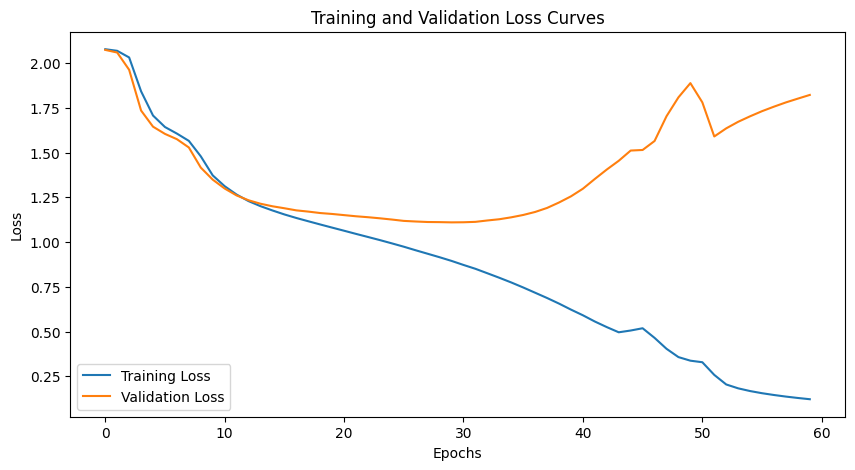

In [29]:
train_losses = logger.logs['train_loss']
val_losses = logger.logs['val_loss']
plot_loss_curves(train_losses, val_losses)

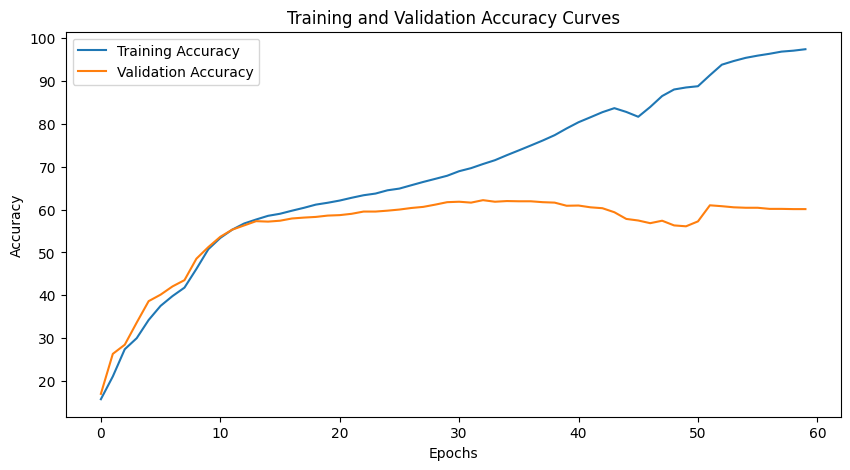

In [30]:
train_accuracies = [acc for acc in logger.logs['train_acc']]
val_accuracies = [acc for acc in logger.logs['val_acc']]
plot_accuracy_curves(train_accuracies, val_accuracies)

Test Loss: 1.8397
Test Accuracy: 59.27%


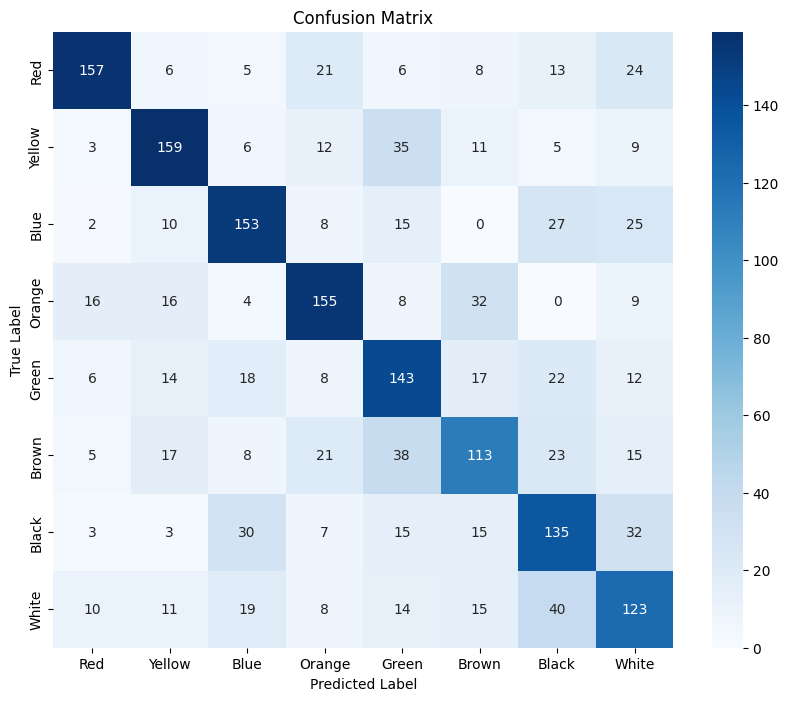

In [31]:
y_true = y_test  # Directly use y_test
y_pred = []

with torch.no_grad():
    model.eval()
    for X, y in test_data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

# Print Test Loss and Test Accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_confusion_matrix(y_true, y_pred, labels)

Inference Time Model Profiling

In [32]:
# Evaluate inference time
model.eval()
total_inference_time = 0
total_batches = 0

with torch.no_grad():
    for X, y in tqdm(test_data_loader, unit="batch", desc="Test Inference Time Evaluation"):
        X, y = X.to('cuda'), y.to('cuda')

        start_time = time.time()
        pred = model(X)
        end_time = time.time()

        inference_time = (end_time - start_time) * 1000  # Time in milliseconds
        total_inference_time += inference_time
        total_batches += 1

average_inference_time = total_inference_time / total_batches
print(f"Average Inference Time per Batch: {average_inference_time:.3f} ms")

Test Inference Time Evaluation: 100%|██████████| 60/60 [00:01<00:00, 58.21batch/s]

Average Inference Time per Batch: 0.771 ms


## Modelo 3- Updated Twin Network Model

Key Modifications:
1. Increased Depth and Filters: Each path now has deeper layers with more filters, improving the model's ability to learn more complex features.
2. Dropout: Added dropout at multiple stages within each path to help prevent overfitting.
3. Batch Normalization: Used in each convolutional block to stabilize learning and improve convergence rates.

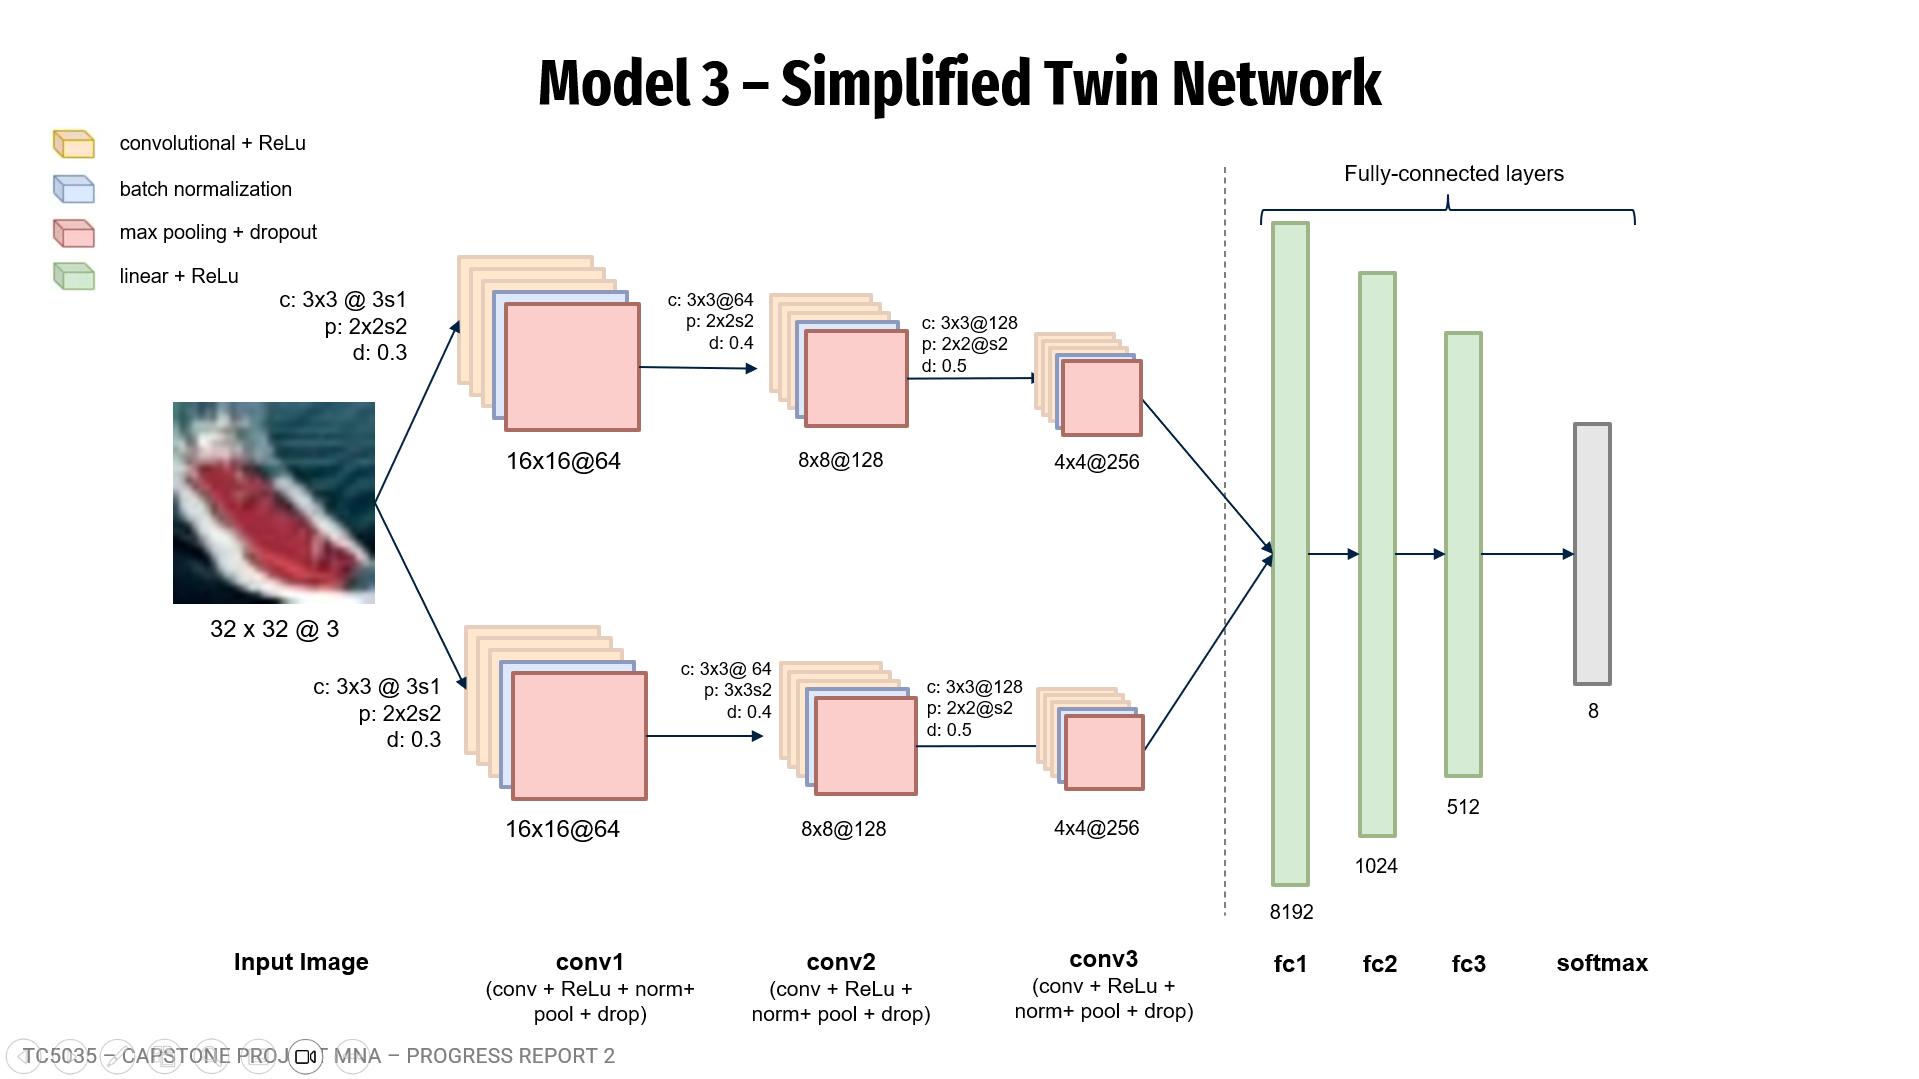

In [33]:
class ColorModel3(nn.Module):
    def __init__(self):
        super(ColorModel3, self).__init__()
        # Initial common convolution layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Top path
        self.top_path = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )

        # Bottom path
        self.bottom_path = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, 8)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x_top = self.top_path(x)
        x_bottom = self.bottom_path(x)
        x = torch.cat((x_top, x_bottom), dim=1)
        #print("Shape before flatten:", x.shape)  # Debug print
        x = x.view(x.size(0), -1)
        #print("Shape after flatten:", x.shape)  # Debug print
        x = self.classifier(x)
        return x

In [34]:
# Save Model
Model_Path = '/content/models/model3'
logger = Logger(Model_Path, "model3_updated_twin_network", 1)

In [35]:
model = ColorModel3()
model.cuda()
opt = torch.optim.SGD(model.parameters(), momentum=0.9, lr = 0.001 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=20,min_lr=1e-08,factor=0.1,verbose=True)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [36]:
# Print the summary of the model
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 16, 16]               0
           Dropout-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         MaxPool2d-9            [-1, 128, 8, 8]               0
          Dropout-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
      BatchNorm2d-13            [-1, 256, 8, 8]             512
        MaxPool2d-14            [-1, 25

In [37]:
# Training Loop
epochs = 60
for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0
    batch_ = 0
    total_correct = 0  # For accuracy calculation
    total_samples = 0  # For accuracy calculation

    for X, y in tqdm(train_data_loader, unit="batch", desc=f"Train | Epoch {epoch}"):
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        loss_value = loss_fn(pred, y)
        loss_value.backward()
        opt.step()
        opt.zero_grad()

        # Calculate the loss
        running_loss += loss_value.item()

        # Calculate accuracy
        pred_class = pred.argmax(dim=1)
        total_correct += (pred_class == y).sum().item()
        total_samples += y.size(0)

        batch_ += 1

    train_loss = running_loss / batch_
    train_accuracy = (total_correct / total_samples) * 100  # Calculate training accuracy percentage
    logger.log('train_loss', train_loss)
    logger.log('train_acc', train_accuracy)

    # Validation Phase
    model.eval()
    val_running_loss = 0
    val_batch = 0
    correct = 0
    for X, y in tqdm(val_data_loader, unit="batch", desc=f"Val | Epoch {epoch}"):
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        loss_value = loss_fn(pred, y)
        val_running_loss += loss_value.item()
        pred_class = pred.argmax(dim=1)
        correct += (pred_class == y).float().sum().item()
        val_batch += 1
    val_loss = val_running_loss / val_batch
    val_accuracy = correct / (val_batch * 32) * 100  # Assuming the batch size is constant
    logger.log('val_loss', val_loss)
    logger.log('val_acc', val_accuracy)

    # Print the validation loss and accuracy
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Update learning rate scheduler if needed based on validation loss
    lr_scheduler.step(val_loss)

    # Checkpoint the model (optional, based on your checkpointing strategy)
    logger.checkpoint(model)

# Test Evaluation at the end of training
model.eval()
test_running_loss = 0
test_batch = 0
test_correct = 0
for X, y in tqdm(test_data_loader, unit="batch", desc="Test Evaluation"):
    X, y = X.to('cuda'), y.to('cuda')
    pred = model(X)
    loss_value = loss_fn(pred, y)
    test_running_loss += loss_value.item()
    pred_class = pred.argmax(dim=1)
    test_correct += (pred_class == y).float().sum().item()
    test_batch += 1
test_loss = test_running_loss / test_batch
test_accuracy = test_correct / (test_batch * 32) * 100  # Assuming the batch size is constant
logger.log('test_loss', test_loss)
logger.log('test_acc', test_accuracy)

# Print Test Loss and Test Accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Train | Epoch 0: 100%|██████████| 280/280 [00:06<00:00, 43.44batch/s]
Val | Epoch 0: 100%|██████████| 60/60 [00:01<00:00, 53.85batch/s]


Validation Loss: 1.5740, Validation Accuracy: 45.31%
Saving Model...


Train | Epoch 1: 100%|██████████| 280/280 [00:06<00:00, 43.23batch/s]
Val | Epoch 1: 100%|██████████| 60/60 [00:01<00:00, 53.81batch/s]


Validation Loss: 1.4307, Validation Accuracy: 50.36%
Saving Model...


Train | Epoch 2: 100%|██████████| 280/280 [00:06<00:00, 44.03batch/s]
Val | Epoch 2: 100%|██████████| 60/60 [00:01<00:00, 53.97batch/s]


Validation Loss: 1.3253, Validation Accuracy: 53.39%
Saving Model...


Train | Epoch 3: 100%|██████████| 280/280 [00:06<00:00, 43.19batch/s]
Val | Epoch 3: 100%|██████████| 60/60 [00:01<00:00, 54.12batch/s]


Validation Loss: 1.2660, Validation Accuracy: 55.62%
Saving Model...


Train | Epoch 4: 100%|██████████| 280/280 [00:06<00:00, 43.77batch/s]
Val | Epoch 4: 100%|██████████| 60/60 [00:01<00:00, 53.95batch/s]


Validation Loss: 1.2347, Validation Accuracy: 55.57%
Saving Model...


Train | Epoch 5: 100%|██████████| 280/280 [00:06<00:00, 43.87batch/s]
Val | Epoch 5: 100%|██████████| 60/60 [00:01<00:00, 53.78batch/s]


Validation Loss: 1.2001, Validation Accuracy: 57.29%
Saving Model...


Train | Epoch 6: 100%|██████████| 280/280 [00:06<00:00, 43.60batch/s]
Val | Epoch 6: 100%|██████████| 60/60 [00:01<00:00, 54.34batch/s]


Validation Loss: 1.1982, Validation Accuracy: 57.60%
Saving Model...


Train | Epoch 7: 100%|██████████| 280/280 [00:06<00:00, 43.83batch/s]
Val | Epoch 7: 100%|██████████| 60/60 [00:01<00:00, 53.56batch/s]


Validation Loss: 1.1792, Validation Accuracy: 58.91%
Saving Model...


Train | Epoch 8: 100%|██████████| 280/280 [00:06<00:00, 44.03batch/s]
Val | Epoch 8: 100%|██████████| 60/60 [00:01<00:00, 54.31batch/s]


Validation Loss: 1.1934, Validation Accuracy: 57.34%
Saving Model...


Train | Epoch 9: 100%|██████████| 280/280 [00:06<00:00, 43.84batch/s]
Val | Epoch 9: 100%|██████████| 60/60 [00:01<00:00, 53.91batch/s]


Validation Loss: 1.1516, Validation Accuracy: 59.43%
Saving Model...


Train | Epoch 10: 100%|██████████| 280/280 [00:06<00:00, 43.77batch/s]
Val | Epoch 10: 100%|██████████| 60/60 [00:01<00:00, 53.98batch/s]


Validation Loss: 1.1462, Validation Accuracy: 60.10%
Saving Model...


Train | Epoch 11: 100%|██████████| 280/280 [00:06<00:00, 44.10batch/s]
Val | Epoch 11: 100%|██████████| 60/60 [00:01<00:00, 52.49batch/s]


Validation Loss: 1.1647, Validation Accuracy: 59.53%
Saving Model...


Train | Epoch 12: 100%|██████████| 280/280 [00:06<00:00, 43.77batch/s]
Val | Epoch 12: 100%|██████████| 60/60 [00:01<00:00, 54.86batch/s]


Validation Loss: 1.1451, Validation Accuracy: 60.89%
Saving Model...


Train | Epoch 13: 100%|██████████| 280/280 [00:06<00:00, 43.47batch/s]
Val | Epoch 13: 100%|██████████| 60/60 [00:01<00:00, 54.24batch/s]


Validation Loss: 1.1276, Validation Accuracy: 60.89%
Saving Model...


Train | Epoch 14: 100%|██████████| 280/280 [00:06<00:00, 44.01batch/s]
Val | Epoch 14: 100%|██████████| 60/60 [00:01<00:00, 53.72batch/s]


Validation Loss: 1.1357, Validation Accuracy: 60.47%
Saving Model...


Train | Epoch 15: 100%|██████████| 280/280 [00:06<00:00, 43.52batch/s]
Val | Epoch 15: 100%|██████████| 60/60 [00:01<00:00, 54.19batch/s]


Validation Loss: 1.1238, Validation Accuracy: 61.41%
Saving Model...


Train | Epoch 16: 100%|██████████| 280/280 [00:06<00:00, 43.49batch/s]
Val | Epoch 16: 100%|██████████| 60/60 [00:01<00:00, 53.30batch/s]


Validation Loss: 1.1038, Validation Accuracy: 62.81%
Saving Model...


Train | Epoch 17: 100%|██████████| 280/280 [00:06<00:00, 43.98batch/s]
Val | Epoch 17: 100%|██████████| 60/60 [00:01<00:00, 53.70batch/s]


Validation Loss: 1.1195, Validation Accuracy: 62.40%
Saving Model...


Train | Epoch 18: 100%|██████████| 280/280 [00:06<00:00, 43.81batch/s]
Val | Epoch 18: 100%|██████████| 60/60 [00:01<00:00, 54.21batch/s]


Validation Loss: 1.1576, Validation Accuracy: 60.52%
Saving Model...


Train | Epoch 19: 100%|██████████| 280/280 [00:06<00:00, 43.73batch/s]
Val | Epoch 19: 100%|██████████| 60/60 [00:01<00:00, 50.67batch/s]


Validation Loss: 1.1157, Validation Accuracy: 62.55%
Saving Model...


Train | Epoch 20: 100%|██████████| 280/280 [00:06<00:00, 43.81batch/s]
Val | Epoch 20: 100%|██████████| 60/60 [00:01<00:00, 54.59batch/s]


Validation Loss: 1.0700, Validation Accuracy: 63.75%
Saving Model...


Train | Epoch 21: 100%|██████████| 280/280 [00:06<00:00, 43.57batch/s]
Val | Epoch 21: 100%|██████████| 60/60 [00:01<00:00, 52.87batch/s]


Validation Loss: 1.1438, Validation Accuracy: 61.82%
Saving Model...


Train | Epoch 22: 100%|██████████| 280/280 [00:06<00:00, 44.05batch/s]
Val | Epoch 22: 100%|██████████| 60/60 [00:01<00:00, 53.49batch/s]


Validation Loss: 1.1081, Validation Accuracy: 62.81%
Saving Model...


Train | Epoch 23: 100%|██████████| 280/280 [00:06<00:00, 43.62batch/s]
Val | Epoch 23: 100%|██████████| 60/60 [00:01<00:00, 53.85batch/s]


Validation Loss: 1.0693, Validation Accuracy: 63.12%
Saving Model...


Train | Epoch 24: 100%|██████████| 280/280 [00:06<00:00, 43.73batch/s]
Val | Epoch 24: 100%|██████████| 60/60 [00:01<00:00, 53.87batch/s]


Validation Loss: 1.0748, Validation Accuracy: 63.23%
Saving Model...


Train | Epoch 25: 100%|██████████| 280/280 [00:06<00:00, 43.75batch/s]
Val | Epoch 25: 100%|██████████| 60/60 [00:01<00:00, 53.93batch/s]


Validation Loss: 1.0690, Validation Accuracy: 63.54%
Saving Model...


Train | Epoch 26: 100%|██████████| 280/280 [00:06<00:00, 43.45batch/s]
Val | Epoch 26: 100%|██████████| 60/60 [00:01<00:00, 54.42batch/s]


Validation Loss: 1.0791, Validation Accuracy: 64.32%
Saving Model...


Train | Epoch 27: 100%|██████████| 280/280 [00:06<00:00, 43.34batch/s]
Val | Epoch 27: 100%|██████████| 60/60 [00:01<00:00, 53.99batch/s]


Validation Loss: 1.1129, Validation Accuracy: 63.23%
Saving Model...


Train | Epoch 28: 100%|██████████| 280/280 [00:06<00:00, 43.87batch/s]
Val | Epoch 28: 100%|██████████| 60/60 [00:01<00:00, 53.72batch/s]


Validation Loss: 1.0675, Validation Accuracy: 64.90%
Saving Model...


Train | Epoch 29: 100%|██████████| 280/280 [00:06<00:00, 43.53batch/s]
Val | Epoch 29: 100%|██████████| 60/60 [00:01<00:00, 54.11batch/s]


Validation Loss: 1.0563, Validation Accuracy: 65.52%
Saving Model...


Train | Epoch 30: 100%|██████████| 280/280 [00:06<00:00, 43.55batch/s]
Val | Epoch 30: 100%|██████████| 60/60 [00:01<00:00, 53.56batch/s]


Validation Loss: 1.0796, Validation Accuracy: 64.74%
Saving Model...


Train | Epoch 31: 100%|██████████| 280/280 [00:06<00:00, 43.69batch/s]
Val | Epoch 31: 100%|██████████| 60/60 [00:01<00:00, 54.00batch/s]


Validation Loss: 1.1032, Validation Accuracy: 63.96%
Saving Model...


Train | Epoch 32: 100%|██████████| 280/280 [00:06<00:00, 43.50batch/s]
Val | Epoch 32: 100%|██████████| 60/60 [00:01<00:00, 53.56batch/s]


Validation Loss: 1.1262, Validation Accuracy: 62.97%
Saving Model...


Train | Epoch 33: 100%|██████████| 280/280 [00:06<00:00, 43.65batch/s]
Val | Epoch 33: 100%|██████████| 60/60 [00:01<00:00, 54.07batch/s]


Validation Loss: 1.0857, Validation Accuracy: 64.64%
Saving Model...


Train | Epoch 34: 100%|██████████| 280/280 [00:06<00:00, 44.01batch/s]
Val | Epoch 34: 100%|██████████| 60/60 [00:01<00:00, 53.98batch/s]


Validation Loss: 1.1138, Validation Accuracy: 64.64%
Saving Model...


Train | Epoch 35: 100%|██████████| 280/280 [00:06<00:00, 43.66batch/s]
Val | Epoch 35: 100%|██████████| 60/60 [00:01<00:00, 53.85batch/s]


Validation Loss: 1.1472, Validation Accuracy: 63.70%
Saving Model...


Train | Epoch 36: 100%|██████████| 280/280 [00:06<00:00, 43.61batch/s]
Val | Epoch 36: 100%|██████████| 60/60 [00:01<00:00, 53.36batch/s]


Validation Loss: 1.0950, Validation Accuracy: 64.79%
Saving Model...


Train | Epoch 37: 100%|██████████| 280/280 [00:06<00:00, 44.04batch/s]
Val | Epoch 37: 100%|██████████| 60/60 [00:01<00:00, 54.20batch/s]


Validation Loss: 1.1007, Validation Accuracy: 64.90%
Saving Model...


Train | Epoch 38: 100%|██████████| 280/280 [00:06<00:00, 43.78batch/s]
Val | Epoch 38: 100%|██████████| 60/60 [00:01<00:00, 53.96batch/s]


Validation Loss: 1.1038, Validation Accuracy: 64.90%
Saving Model...


Train | Epoch 39: 100%|██████████| 280/280 [00:06<00:00, 43.91batch/s]
Val | Epoch 39: 100%|██████████| 60/60 [00:01<00:00, 53.54batch/s]


Validation Loss: 1.1355, Validation Accuracy: 64.84%
Saving Model...


Train | Epoch 40: 100%|██████████| 280/280 [00:06<00:00, 44.06batch/s]
Val | Epoch 40: 100%|██████████| 60/60 [00:01<00:00, 53.88batch/s]


Validation Loss: 1.1197, Validation Accuracy: 65.36%
Saving Model...


Train | Epoch 41: 100%|██████████| 280/280 [00:06<00:00, 43.62batch/s]
Val | Epoch 41: 100%|██████████| 60/60 [00:01<00:00, 54.36batch/s]


Validation Loss: 1.1169, Validation Accuracy: 65.68%
Saving Model...


Train | Epoch 42: 100%|██████████| 280/280 [00:06<00:00, 44.00batch/s]
Val | Epoch 42: 100%|██████████| 60/60 [00:01<00:00, 52.10batch/s]


Validation Loss: 1.1476, Validation Accuracy: 64.79%
Saving Model...


Train | Epoch 43: 100%|██████████| 280/280 [00:06<00:00, 43.76batch/s]
Val | Epoch 43: 100%|██████████| 60/60 [00:01<00:00, 54.40batch/s]


Validation Loss: 1.1677, Validation Accuracy: 64.79%
Saving Model...


Train | Epoch 44: 100%|██████████| 280/280 [00:06<00:00, 42.85batch/s]
Val | Epoch 44: 100%|██████████| 60/60 [00:01<00:00, 54.31batch/s]


Validation Loss: 1.1267, Validation Accuracy: 65.62%
Saving Model...


Train | Epoch 45: 100%|██████████| 280/280 [00:06<00:00, 43.83batch/s]
Val | Epoch 45: 100%|██████████| 60/60 [00:01<00:00, 53.72batch/s]


Validation Loss: 1.1384, Validation Accuracy: 64.58%
Saving Model...


Train | Epoch 46: 100%|██████████| 280/280 [00:06<00:00, 43.48batch/s]
Val | Epoch 46: 100%|██████████| 60/60 [00:01<00:00, 54.27batch/s]


Validation Loss: 1.1552, Validation Accuracy: 66.15%
Saving Model...


Train | Epoch 47: 100%|██████████| 280/280 [00:06<00:00, 43.40batch/s]
Val | Epoch 47: 100%|██████████| 60/60 [00:01<00:00, 53.73batch/s]


Validation Loss: 1.1887, Validation Accuracy: 64.90%
Saving Model...


Train | Epoch 48: 100%|██████████| 280/280 [00:06<00:00, 43.76batch/s]
Val | Epoch 48: 100%|██████████| 60/60 [00:01<00:00, 53.02batch/s]


Validation Loss: 1.1815, Validation Accuracy: 66.15%
Saving Model...


Train | Epoch 49: 100%|██████████| 280/280 [00:06<00:00, 43.81batch/s]
Val | Epoch 49: 100%|██████████| 60/60 [00:01<00:00, 53.92batch/s]


Validation Loss: 1.1933, Validation Accuracy: 66.15%
Saving Model...


Train | Epoch 50: 100%|██████████| 280/280 [00:06<00:00, 43.79batch/s]
Val | Epoch 50: 100%|██████████| 60/60 [00:01<00:00, 53.83batch/s]


Validation Loss: 1.2154, Validation Accuracy: 65.73%
Saving Model...


Train | Epoch 51: 100%|██████████| 280/280 [00:06<00:00, 43.40batch/s]
Val | Epoch 51: 100%|██████████| 60/60 [00:01<00:00, 53.71batch/s]


Validation Loss: 1.2387, Validation Accuracy: 66.30%
Saving Model...


Train | Epoch 52: 100%|██████████| 280/280 [00:06<00:00, 43.34batch/s]
Val | Epoch 52: 100%|██████████| 60/60 [00:01<00:00, 53.91batch/s]


Validation Loss: 1.2395, Validation Accuracy: 66.77%
Saving Model...


Train | Epoch 53: 100%|██████████| 280/280 [00:06<00:00, 43.59batch/s]
Val | Epoch 53: 100%|██████████| 60/60 [00:01<00:00, 53.46batch/s]


Validation Loss: 1.2486, Validation Accuracy: 66.04%
Saving Model...


Train | Epoch 54: 100%|██████████| 280/280 [00:06<00:00, 43.57batch/s]
Val | Epoch 54: 100%|██████████| 60/60 [00:01<00:00, 53.61batch/s]


Validation Loss: 1.2495, Validation Accuracy: 66.46%
Saving Model...


Train | Epoch 55: 100%|██████████| 280/280 [00:06<00:00, 43.38batch/s]
Val | Epoch 55: 100%|██████████| 60/60 [00:01<00:00, 53.81batch/s]


Validation Loss: 1.2476, Validation Accuracy: 66.25%
Saving Model...


Train | Epoch 56: 100%|██████████| 280/280 [00:06<00:00, 43.37batch/s]
Val | Epoch 56: 100%|██████████| 60/60 [00:01<00:00, 53.63batch/s]


Validation Loss: 1.2578, Validation Accuracy: 66.25%
Saving Model...


Train | Epoch 57: 100%|██████████| 280/280 [00:06<00:00, 43.84batch/s]
Val | Epoch 57: 100%|██████████| 60/60 [00:01<00:00, 53.85batch/s]


Validation Loss: 1.2758, Validation Accuracy: 66.25%
Saving Model...


Train | Epoch 58: 100%|██████████| 280/280 [00:06<00:00, 43.58batch/s]
Val | Epoch 58: 100%|██████████| 60/60 [00:01<00:00, 53.46batch/s]


Validation Loss: 1.2735, Validation Accuracy: 66.20%
Saving Model...


Train | Epoch 59: 100%|██████████| 280/280 [00:06<00:00, 43.15batch/s]
Val | Epoch 59: 100%|██████████| 60/60 [00:01<00:00, 53.68batch/s]


Validation Loss: 1.2660, Validation Accuracy: 66.09%
Saving Model...


Test Evaluation: 100%|██████████| 60/60 [00:01<00:00, 54.18batch/s]

Test Loss: 1.3433
Test Accuracy: 64.48%


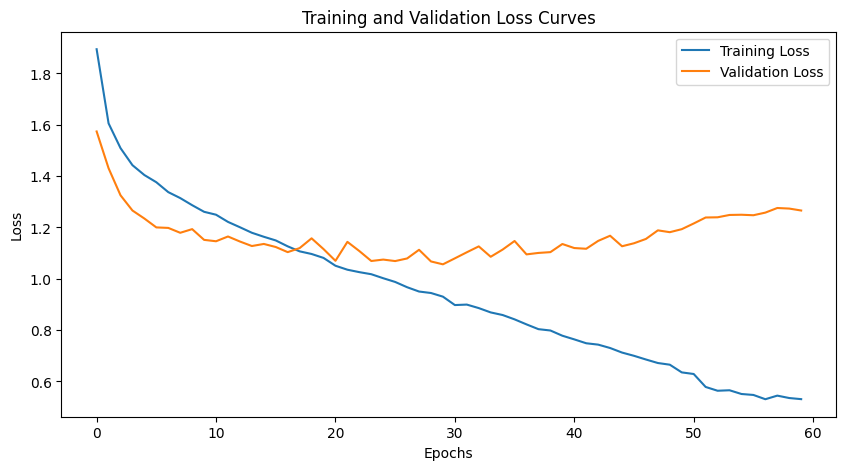

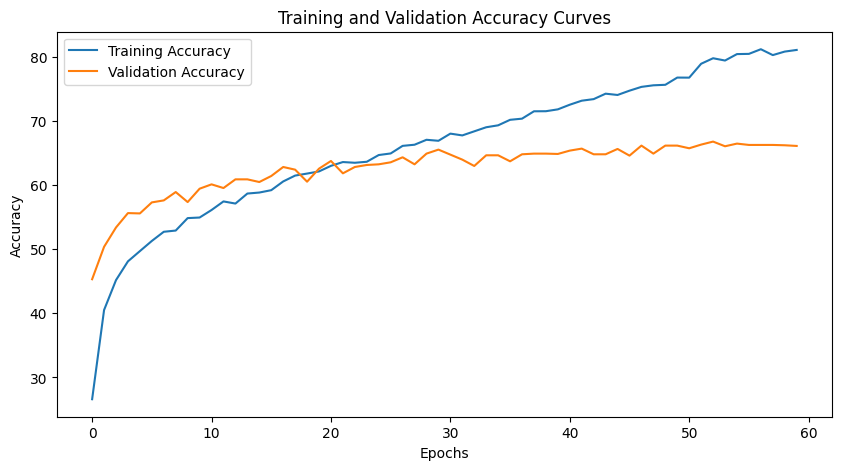

Test Loss: 1.3433
Test Accuracy: 64.48%


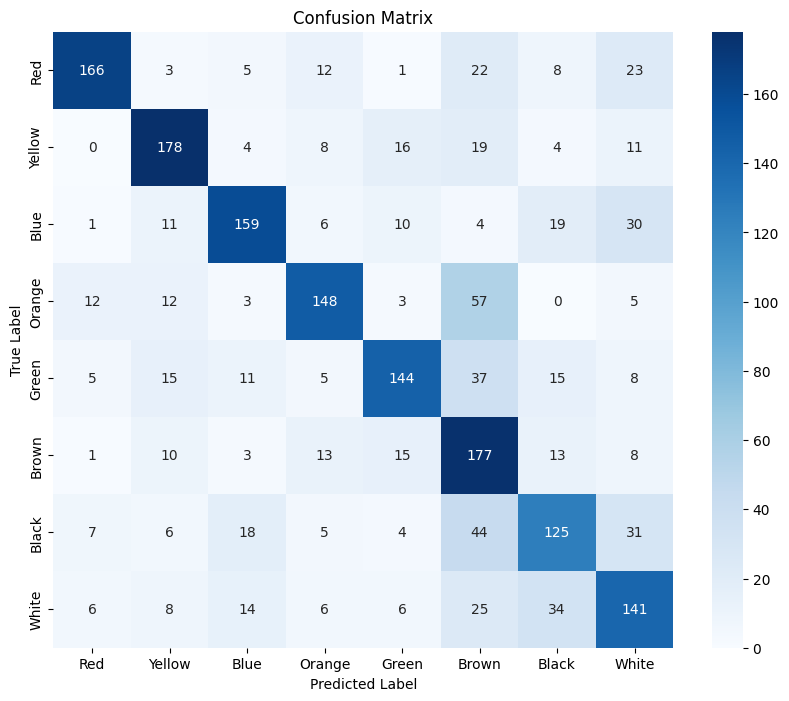

In [38]:
# Performance Metrics

train_losses = logger.logs['train_loss']
val_losses = logger.logs['val_loss']
plot_loss_curves(train_losses, val_losses)

train_accuracies = [acc for acc in logger.logs['train_acc']]
val_accuracies = [acc for acc in logger.logs['val_acc']]
plot_accuracy_curves(train_accuracies, val_accuracies)

y_true = y_test  # Directly use y_test
y_pred = []

with torch.no_grad():
    model.eval()
    for X, y in test_data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

# Print Test Loss and Test Accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_confusion_matrix(y_true, y_pred, labels)

Inference Time Model Profiling

In [39]:
# Evaluate inference time
model.eval()
total_inference_time = 0
total_batches = 0

with torch.no_grad():
    for X, y in tqdm(test_data_loader, unit="batch", desc="Test Inference Time Evaluation"):
        X, y = X.to('cuda'), y.to('cuda')

        start_time = time.time()
        pred = model(X)
        end_time = time.time()

        inference_time = (end_time - start_time) * 1000  # Time in milliseconds
        total_inference_time += inference_time
        total_batches += 1

average_inference_time = total_inference_time / total_batches
print(f"Average Inference Time per Batch: {average_inference_time:.3f} ms")

Test Inference Time Evaluation: 100%|██████████| 60/60 [00:01<00:00, 56.37batch/s]

Average Inference Time per Batch: 1.499 ms


## Modelo 4 - VGG-16 Base Single Network

Proposed "ColorModel4" Architecture:
1. Input Size: The input size for CIFAR-10 is relatively small (32x32), which means fewer convolutional layers can be used before reaching the fully connected layers, to prevent reducing the spatial dimensions too much.

2. Convolutions: VGG networks use small (3x3) convolution filters, which we will also use. To prevent too rapid reduction of image dimensions, some convolution layers won't use padding, and the number of pooling layers will be reduced.

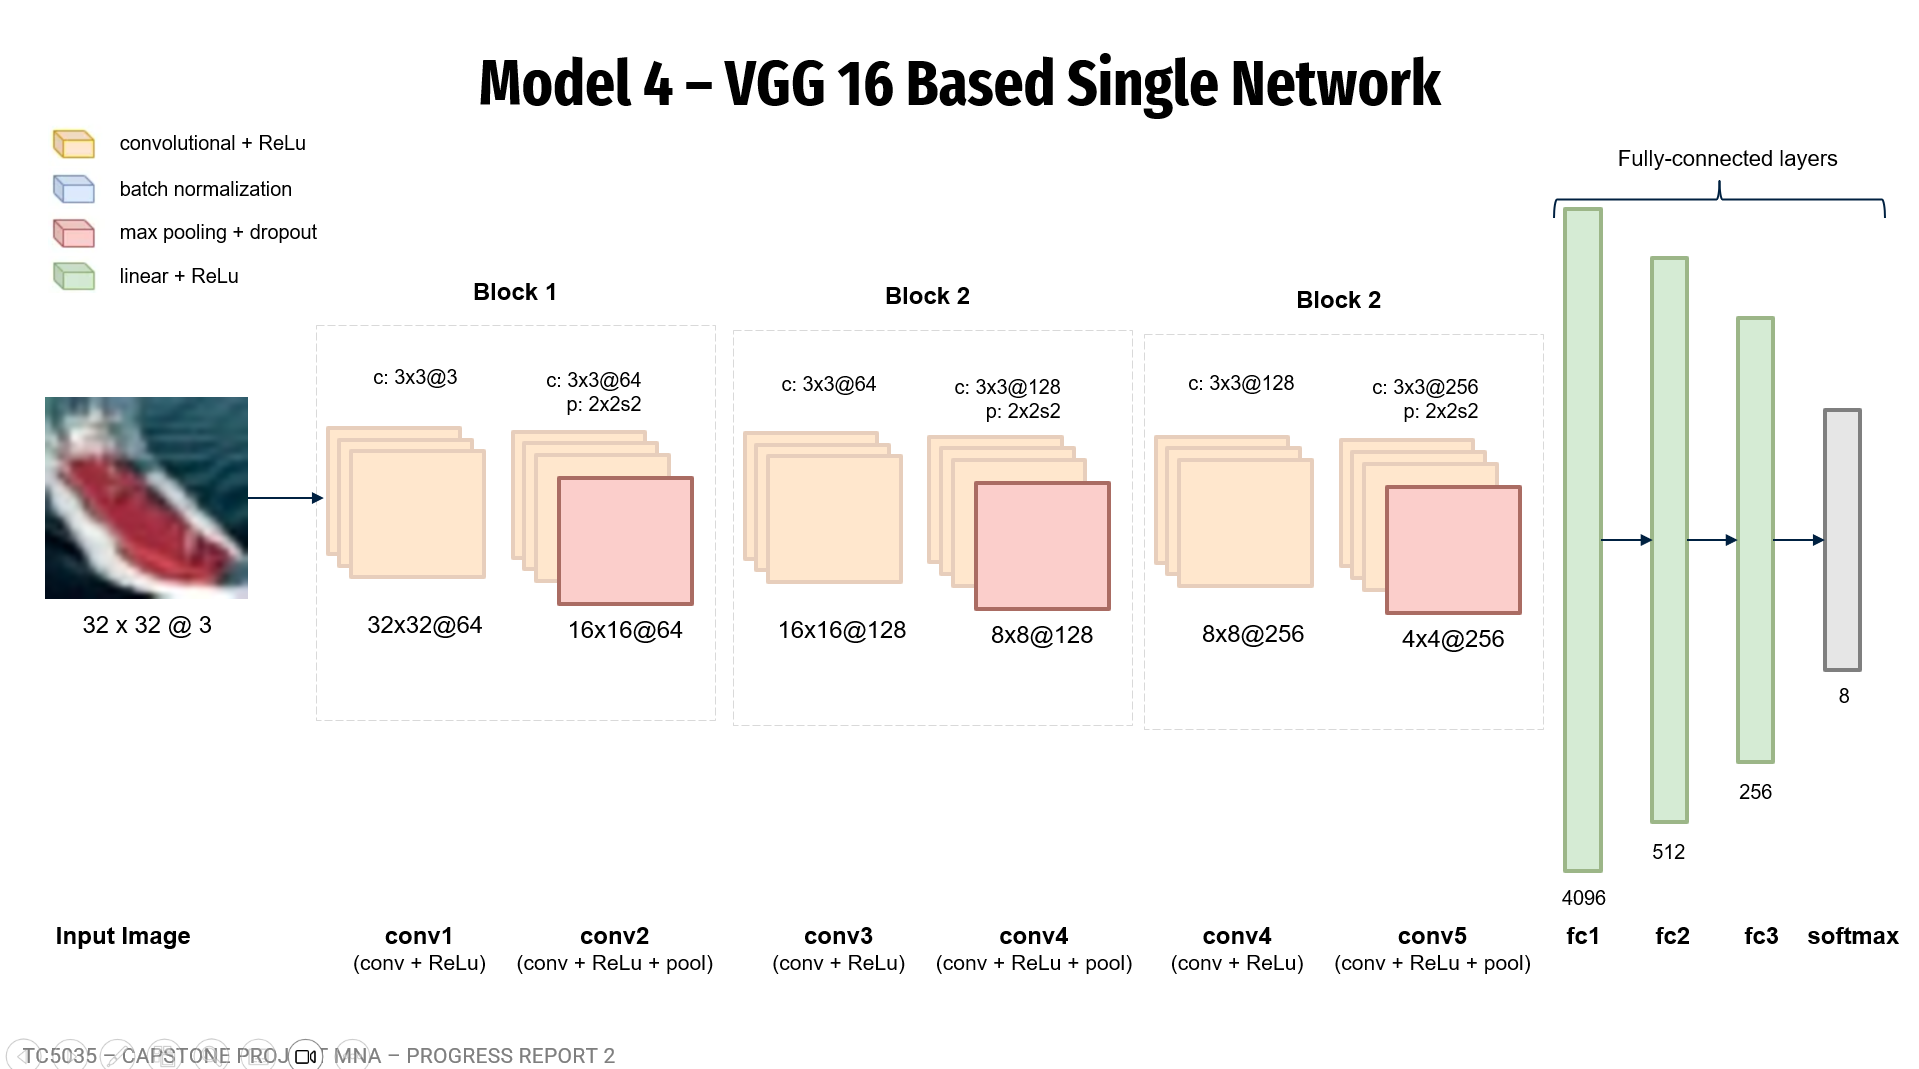

In [40]:
class ColorModel4(nn.Module):
    def __init__(self):
        super(ColorModel4, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # No padding here
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),  # Adjusted for the flattened output of the final pooling layer
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 8)  # Output layer for 8 classes
        )

    def forward(self, x):
        x = self.features(x)
        #print(f"Output shape after features: {x.size()}")  # Debug print
        x = x.view(-1, 256 * 4 * 4)  # Flatten the output
        #print(f"Shape before classifier: {x.size()}")  # Debug print
        x = self.classifier(x)
        #print(f"Shape after classifier: {x.size()}")  # Debug print
        return x

In [41]:
# Save Model
Model_Path = '/content/models/model4'
logger = Logger(Model_Path, "model4_vgg16", 1)

In [42]:
model = ColorModel4()
model.cuda()
opt = torch.optim.SGD(model.parameters(), momentum=0.9, lr = 0.001 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=20,min_lr=1e-08,factor=0.1,verbose=True)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [43]:
# Print the summary of the model
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [44]:
# Training Loop
epochs = 100
for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0
    batch_ = 0
    total_correct = 0  # For accuracy calculation
    total_samples = 0  # For accuracy calculation

    for X, y in tqdm(train_data_loader, unit="batch", desc=f"Train | Epoch {epoch}"):
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        loss_value = loss_fn(pred, y)
        loss_value.backward()
        opt.step()
        opt.zero_grad()

        # Calculate the loss
        running_loss += loss_value.item()

        # Calculate accuracy
        pred_class = pred.argmax(dim=1)
        total_correct += (pred_class == y).sum().item()
        total_samples += y.size(0)

        batch_ += 1

    train_loss = running_loss / batch_
    train_accuracy = (total_correct / total_samples) * 100  # Calculate training accuracy percentage
    logger.log('train_loss', train_loss)
    logger.log('train_acc', train_accuracy)

    # Validation Phase
    model.eval()
    val_running_loss = 0
    val_batch = 0
    correct = 0
    for X, y in tqdm(val_data_loader, unit="batch", desc=f"Val | Epoch {epoch}"):
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        loss_value = loss_fn(pred, y)
        val_running_loss += loss_value.item()
        pred_class = pred.argmax(dim=1)
        correct += (pred_class == y).float().sum().item()
        val_batch += 1
    val_loss = val_running_loss / val_batch
    val_accuracy = correct / (val_batch * 32) * 100  # Assuming the batch size is constant
    logger.log('val_loss', val_loss)
    logger.log('val_acc', val_accuracy)

    # Print the validation loss and accuracy
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Update learning rate scheduler if needed based on validation loss
    lr_scheduler.step(val_loss)

    # Checkpoint the model (optional, based on your checkpointing strategy)
    logger.checkpoint(model)

# Test Evaluation at the end of training
model.eval()
test_running_loss = 0
test_batch = 0
test_correct = 0
for X, y in tqdm(test_data_loader, unit="batch", desc="Test Evaluation"):
    X, y = X.to('cuda'), y.to('cuda')
    pred = model(X)
    loss_value = loss_fn(pred, y)
    test_running_loss += loss_value.item()
    pred_class = pred.argmax(dim=1)
    test_correct += (pred_class == y).float().sum().item()
    test_batch += 1
test_loss = test_running_loss / test_batch
test_accuracy = test_correct / (test_batch * 32) * 100  # Assuming the batch size is constant
logger.log('test_loss', test_loss)
logger.log('test_acc', test_accuracy)

# Print Test Loss and Test Accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Train | Epoch 0: 100%|██████████| 280/280 [00:05<00:00, 47.67batch/s]
Val | Epoch 0: 100%|██████████| 60/60 [00:01<00:00, 56.04batch/s]


Validation Loss: 2.0796, Validation Accuracy: 12.60%
Saving Model...


Train | Epoch 1: 100%|██████████| 280/280 [00:05<00:00, 47.97batch/s]
Val | Epoch 1: 100%|██████████| 60/60 [00:01<00:00, 55.51batch/s]


Validation Loss: 2.0795, Validation Accuracy: 13.23%
Saving Model...


Train | Epoch 2: 100%|██████████| 280/280 [00:05<00:00, 47.96batch/s]
Val | Epoch 2: 100%|██████████| 60/60 [00:01<00:00, 55.29batch/s]


Validation Loss: 2.0794, Validation Accuracy: 12.92%
Saving Model...


Train | Epoch 3: 100%|██████████| 280/280 [00:05<00:00, 48.31batch/s]
Val | Epoch 3: 100%|██████████| 60/60 [00:01<00:00, 55.20batch/s]


Validation Loss: 2.0793, Validation Accuracy: 13.85%
Saving Model...


Train | Epoch 4: 100%|██████████| 280/280 [00:05<00:00, 48.13batch/s]
Val | Epoch 4: 100%|██████████| 60/60 [00:01<00:00, 54.89batch/s]


Validation Loss: 2.0792, Validation Accuracy: 14.84%
Saving Model...


Train | Epoch 5: 100%|██████████| 280/280 [00:05<00:00, 47.85batch/s]
Val | Epoch 5: 100%|██████████| 60/60 [00:01<00:00, 55.25batch/s]


Validation Loss: 2.0792, Validation Accuracy: 14.32%
Saving Model...


Train | Epoch 6: 100%|██████████| 280/280 [00:05<00:00, 48.20batch/s]
Val | Epoch 6: 100%|██████████| 60/60 [00:01<00:00, 55.22batch/s]


Validation Loss: 2.0791, Validation Accuracy: 12.50%
Saving Model...


Train | Epoch 7: 100%|██████████| 280/280 [00:05<00:00, 48.26batch/s]
Val | Epoch 7: 100%|██████████| 60/60 [00:01<00:00, 56.39batch/s]


Validation Loss: 2.0791, Validation Accuracy: 12.76%
Saving Model...


Train | Epoch 8: 100%|██████████| 280/280 [00:05<00:00, 48.11batch/s]
Val | Epoch 8: 100%|██████████| 60/60 [00:01<00:00, 55.43batch/s]


Validation Loss: 2.0790, Validation Accuracy: 12.66%
Saving Model...


Train | Epoch 9: 100%|██████████| 280/280 [00:05<00:00, 47.70batch/s]
Val | Epoch 9: 100%|██████████| 60/60 [00:01<00:00, 55.24batch/s]


Validation Loss: 2.0788, Validation Accuracy: 12.50%
Saving Model...


Train | Epoch 10: 100%|██████████| 280/280 [00:05<00:00, 48.04batch/s]
Val | Epoch 10: 100%|██████████| 60/60 [00:01<00:00, 54.75batch/s]


Validation Loss: 2.0787, Validation Accuracy: 12.50%
Saving Model...


Train | Epoch 11: 100%|██████████| 280/280 [00:05<00:00, 48.38batch/s]
Val | Epoch 11: 100%|██████████| 60/60 [00:01<00:00, 55.61batch/s]


Validation Loss: 2.0785, Validation Accuracy: 14.32%
Saving Model...


Train | Epoch 12: 100%|██████████| 280/280 [00:05<00:00, 48.05batch/s]
Val | Epoch 12: 100%|██████████| 60/60 [00:01<00:00, 55.84batch/s]


Validation Loss: 2.0781, Validation Accuracy: 16.82%
Saving Model...


Train | Epoch 13: 100%|██████████| 280/280 [00:05<00:00, 48.05batch/s]
Val | Epoch 13: 100%|██████████| 60/60 [00:01<00:00, 54.74batch/s]


Validation Loss: 2.0775, Validation Accuracy: 18.80%
Saving Model...


Train | Epoch 14: 100%|██████████| 280/280 [00:05<00:00, 48.06batch/s]
Val | Epoch 14: 100%|██████████| 60/60 [00:01<00:00, 54.95batch/s]


Validation Loss: 2.0764, Validation Accuracy: 19.64%
Saving Model...


Train | Epoch 15: 100%|██████████| 280/280 [00:05<00:00, 48.14batch/s]
Val | Epoch 15: 100%|██████████| 60/60 [00:01<00:00, 55.08batch/s]


Validation Loss: 2.0743, Validation Accuracy: 21.15%
Saving Model...


Train | Epoch 16: 100%|██████████| 280/280 [00:05<00:00, 48.40batch/s]
Val | Epoch 16: 100%|██████████| 60/60 [00:01<00:00, 56.62batch/s]


Validation Loss: 2.0684, Validation Accuracy: 19.64%
Saving Model...


Train | Epoch 17: 100%|██████████| 280/280 [00:05<00:00, 47.81batch/s]
Val | Epoch 17: 100%|██████████| 60/60 [00:01<00:00, 55.08batch/s]


Validation Loss: 2.0476, Validation Accuracy: 19.95%
Saving Model...


Train | Epoch 18: 100%|██████████| 280/280 [00:05<00:00, 48.33batch/s]
Val | Epoch 18: 100%|██████████| 60/60 [00:01<00:00, 55.24batch/s]


Validation Loss: 1.9877, Validation Accuracy: 25.21%
Saving Model...


Train | Epoch 19: 100%|██████████| 280/280 [00:05<00:00, 47.90batch/s]
Val | Epoch 19: 100%|██████████| 60/60 [00:01<00:00, 55.54batch/s]


Validation Loss: 1.8483, Validation Accuracy: 25.52%
Saving Model...


Train | Epoch 20: 100%|██████████| 280/280 [00:05<00:00, 48.54batch/s]
Val | Epoch 20: 100%|██████████| 60/60 [00:01<00:00, 55.47batch/s]


Validation Loss: 1.8081, Validation Accuracy: 25.83%
Saving Model...


Train | Epoch 21: 100%|██████████| 280/280 [00:05<00:00, 48.58batch/s]
Val | Epoch 21: 100%|██████████| 60/60 [00:01<00:00, 56.06batch/s]


Validation Loss: 1.7526, Validation Accuracy: 28.80%
Saving Model...


Train | Epoch 22: 100%|██████████| 280/280 [00:05<00:00, 48.10batch/s]
Val | Epoch 22: 100%|██████████| 60/60 [00:01<00:00, 54.64batch/s]


Validation Loss: 1.7097, Validation Accuracy: 32.55%
Saving Model...


Train | Epoch 23: 100%|██████████| 280/280 [00:05<00:00, 48.50batch/s]
Val | Epoch 23: 100%|██████████| 60/60 [00:01<00:00, 55.57batch/s]


Validation Loss: 1.6624, Validation Accuracy: 35.52%
Saving Model...


Train | Epoch 24: 100%|██████████| 280/280 [00:05<00:00, 48.36batch/s]
Val | Epoch 24: 100%|██████████| 60/60 [00:01<00:00, 55.87batch/s]


Validation Loss: 1.6401, Validation Accuracy: 36.35%
Saving Model...


Train | Epoch 25: 100%|██████████| 280/280 [00:05<00:00, 48.09batch/s]
Val | Epoch 25: 100%|██████████| 60/60 [00:01<00:00, 55.23batch/s]


Validation Loss: 1.6067, Validation Accuracy: 40.00%
Saving Model...


Train | Epoch 26: 100%|██████████| 280/280 [00:05<00:00, 47.43batch/s]
Val | Epoch 26: 100%|██████████| 60/60 [00:01<00:00, 55.45batch/s]


Validation Loss: 1.5656, Validation Accuracy: 42.19%
Saving Model...


Train | Epoch 27: 100%|██████████| 280/280 [00:05<00:00, 48.51batch/s]
Val | Epoch 27: 100%|██████████| 60/60 [00:01<00:00, 56.47batch/s]


Validation Loss: 1.5418, Validation Accuracy: 43.65%
Saving Model...


Train | Epoch 28: 100%|██████████| 280/280 [00:05<00:00, 48.64batch/s]
Val | Epoch 28: 100%|██████████| 60/60 [00:01<00:00, 55.71batch/s]


Validation Loss: 1.4964, Validation Accuracy: 45.36%
Saving Model...


Train | Epoch 29: 100%|██████████| 280/280 [00:05<00:00, 47.83batch/s]
Val | Epoch 29: 100%|██████████| 60/60 [00:01<00:00, 55.15batch/s]


Validation Loss: 1.4268, Validation Accuracy: 48.54%
Saving Model...


Train | Epoch 30: 100%|██████████| 280/280 [00:05<00:00, 48.47batch/s]
Val | Epoch 30: 100%|██████████| 60/60 [00:01<00:00, 55.17batch/s]


Validation Loss: 1.3848, Validation Accuracy: 50.26%
Saving Model...


Train | Epoch 31: 100%|██████████| 280/280 [00:05<00:00, 48.04batch/s]
Val | Epoch 31: 100%|██████████| 60/60 [00:01<00:00, 55.08batch/s]


Validation Loss: 1.3589, Validation Accuracy: 51.15%
Saving Model...


Train | Epoch 32: 100%|██████████| 280/280 [00:05<00:00, 48.25batch/s]
Val | Epoch 32: 100%|██████████| 60/60 [00:01<00:00, 55.02batch/s]


Validation Loss: 1.3298, Validation Accuracy: 51.88%
Saving Model...


Train | Epoch 33: 100%|██████████| 280/280 [00:05<00:00, 48.50batch/s]
Val | Epoch 33: 100%|██████████| 60/60 [00:01<00:00, 55.46batch/s]


Validation Loss: 1.3110, Validation Accuracy: 52.66%
Saving Model...


Train | Epoch 34: 100%|██████████| 280/280 [00:05<00:00, 48.36batch/s]
Val | Epoch 34: 100%|██████████| 60/60 [00:01<00:00, 56.38batch/s]


Validation Loss: 1.3059, Validation Accuracy: 52.60%
Saving Model...


Train | Epoch 35: 100%|██████████| 280/280 [00:05<00:00, 48.02batch/s]
Val | Epoch 35: 100%|██████████| 60/60 [00:01<00:00, 55.70batch/s]


Validation Loss: 1.2901, Validation Accuracy: 53.39%
Saving Model...


Train | Epoch 36: 100%|██████████| 280/280 [00:05<00:00, 48.18batch/s]
Val | Epoch 36: 100%|██████████| 60/60 [00:01<00:00, 55.83batch/s]


Validation Loss: 1.2631, Validation Accuracy: 54.11%
Saving Model...


Train | Epoch 37: 100%|██████████| 280/280 [00:05<00:00, 47.82batch/s]
Val | Epoch 37: 100%|██████████| 60/60 [00:01<00:00, 54.85batch/s]


Validation Loss: 1.2485, Validation Accuracy: 54.95%
Saving Model...


Train | Epoch 38: 100%|██████████| 280/280 [00:05<00:00, 48.42batch/s]
Val | Epoch 38: 100%|██████████| 60/60 [00:01<00:00, 56.00batch/s]


Validation Loss: 1.2518, Validation Accuracy: 54.58%
Saving Model...


Train | Epoch 39: 100%|██████████| 280/280 [00:05<00:00, 48.23batch/s]
Val | Epoch 39: 100%|██████████| 60/60 [00:01<00:00, 55.95batch/s]


Validation Loss: 1.2035, Validation Accuracy: 56.35%
Saving Model...


Train | Epoch 40: 100%|██████████| 280/280 [00:05<00:00, 48.29batch/s]
Val | Epoch 40: 100%|██████████| 60/60 [00:01<00:00, 55.82batch/s]


Validation Loss: 1.2070, Validation Accuracy: 56.09%
Saving Model...


Train | Epoch 41: 100%|██████████| 280/280 [00:05<00:00, 47.57batch/s]
Val | Epoch 41: 100%|██████████| 60/60 [00:01<00:00, 54.78batch/s]


Validation Loss: 1.2028, Validation Accuracy: 56.51%
Saving Model...


Train | Epoch 42: 100%|██████████| 280/280 [00:05<00:00, 47.90batch/s]
Val | Epoch 42: 100%|██████████| 60/60 [00:01<00:00, 55.49batch/s]


Validation Loss: 1.1748, Validation Accuracy: 57.40%
Saving Model...


Train | Epoch 43: 100%|██████████| 280/280 [00:05<00:00, 48.49batch/s]
Val | Epoch 43: 100%|██████████| 60/60 [00:01<00:00, 55.32batch/s]


Validation Loss: 1.1784, Validation Accuracy: 56.88%
Saving Model...


Train | Epoch 44: 100%|██████████| 280/280 [00:05<00:00, 47.83batch/s]
Val | Epoch 44: 100%|██████████| 60/60 [00:01<00:00, 56.31batch/s]


Validation Loss: 1.1606, Validation Accuracy: 58.23%
Saving Model...


Train | Epoch 45: 100%|██████████| 280/280 [00:05<00:00, 48.33batch/s]
Val | Epoch 45: 100%|██████████| 60/60 [00:01<00:00, 56.13batch/s]


Validation Loss: 1.1321, Validation Accuracy: 59.06%
Saving Model...


Train | Epoch 46: 100%|██████████| 280/280 [00:05<00:00, 48.45batch/s]
Val | Epoch 46: 100%|██████████| 60/60 [00:01<00:00, 56.07batch/s]


Validation Loss: 1.1256, Validation Accuracy: 59.90%
Saving Model...


Train | Epoch 47: 100%|██████████| 280/280 [00:05<00:00, 48.64batch/s]
Val | Epoch 47: 100%|██████████| 60/60 [00:01<00:00, 54.89batch/s]


Validation Loss: 1.1281, Validation Accuracy: 59.17%
Saving Model...


Train | Epoch 48: 100%|██████████| 280/280 [00:05<00:00, 48.51batch/s]
Val | Epoch 48: 100%|██████████| 60/60 [00:01<00:00, 56.26batch/s]


Validation Loss: 1.0867, Validation Accuracy: 60.78%
Saving Model...


Train | Epoch 49: 100%|██████████| 280/280 [00:05<00:00, 48.32batch/s]
Val | Epoch 49: 100%|██████████| 60/60 [00:01<00:00, 55.90batch/s]


Validation Loss: 1.0731, Validation Accuracy: 61.77%
Saving Model...


Train | Epoch 50: 100%|██████████| 280/280 [00:05<00:00, 48.33batch/s]
Val | Epoch 50: 100%|██████████| 60/60 [00:01<00:00, 55.58batch/s]


Validation Loss: 1.0810, Validation Accuracy: 61.56%
Saving Model...


Train | Epoch 51: 100%|██████████| 280/280 [00:05<00:00, 48.05batch/s]
Val | Epoch 51: 100%|██████████| 60/60 [00:01<00:00, 56.62batch/s]


Validation Loss: 1.0667, Validation Accuracy: 61.51%
Saving Model...


Train | Epoch 52: 100%|██████████| 280/280 [00:05<00:00, 47.97batch/s]
Val | Epoch 52: 100%|██████████| 60/60 [00:01<00:00, 53.35batch/s]


Validation Loss: 1.0787, Validation Accuracy: 62.08%
Saving Model...


Train | Epoch 53: 100%|██████████| 280/280 [00:05<00:00, 48.25batch/s]
Val | Epoch 53: 100%|██████████| 60/60 [00:01<00:00, 56.35batch/s]


Validation Loss: 1.0444, Validation Accuracy: 62.97%
Saving Model...


Train | Epoch 54: 100%|██████████| 280/280 [00:05<00:00, 48.01batch/s]
Val | Epoch 54: 100%|██████████| 60/60 [00:01<00:00, 55.45batch/s]


Validation Loss: 1.0469, Validation Accuracy: 62.24%
Saving Model...


Train | Epoch 55: 100%|██████████| 280/280 [00:05<00:00, 48.30batch/s]
Val | Epoch 55: 100%|██████████| 60/60 [00:01<00:00, 55.58batch/s]


Validation Loss: 1.0341, Validation Accuracy: 63.02%
Saving Model...


Train | Epoch 56: 100%|██████████| 280/280 [00:05<00:00, 48.09batch/s]
Val | Epoch 56: 100%|██████████| 60/60 [00:01<00:00, 55.64batch/s]


Validation Loss: 1.0572, Validation Accuracy: 63.39%
Saving Model...


Train | Epoch 57: 100%|██████████| 280/280 [00:05<00:00, 48.31batch/s]
Val | Epoch 57: 100%|██████████| 60/60 [00:01<00:00, 54.70batch/s]


Validation Loss: 1.0595, Validation Accuracy: 62.24%
Saving Model...


Train | Epoch 58: 100%|██████████| 280/280 [00:05<00:00, 48.33batch/s]
Val | Epoch 58: 100%|██████████| 60/60 [00:01<00:00, 55.94batch/s]


Validation Loss: 1.0386, Validation Accuracy: 64.06%
Saving Model...


Train | Epoch 59: 100%|██████████| 280/280 [00:05<00:00, 48.19batch/s]
Val | Epoch 59: 100%|██████████| 60/60 [00:01<00:00, 55.27batch/s]


Validation Loss: 1.0687, Validation Accuracy: 63.49%
Saving Model...


Train | Epoch 60: 100%|██████████| 280/280 [00:05<00:00, 48.55batch/s]
Val | Epoch 60: 100%|██████████| 60/60 [00:01<00:00, 56.27batch/s]


Validation Loss: 1.0642, Validation Accuracy: 63.70%
Saving Model...


Train | Epoch 61: 100%|██████████| 280/280 [00:05<00:00, 48.02batch/s]
Val | Epoch 61: 100%|██████████| 60/60 [00:01<00:00, 53.07batch/s]


Validation Loss: 1.0731, Validation Accuracy: 63.54%
Saving Model...


Train | Epoch 62: 100%|██████████| 280/280 [00:05<00:00, 48.58batch/s]
Val | Epoch 62: 100%|██████████| 60/60 [00:01<00:00, 54.93batch/s]


Validation Loss: 1.0775, Validation Accuracy: 63.49%
Saving Model...


Train | Epoch 63: 100%|██████████| 280/280 [00:05<00:00, 48.38batch/s]
Val | Epoch 63: 100%|██████████| 60/60 [00:01<00:00, 55.99batch/s]


Validation Loss: 1.1041, Validation Accuracy: 63.07%
Saving Model...


Train | Epoch 64: 100%|██████████| 280/280 [00:05<00:00, 47.81batch/s]
Val | Epoch 64: 100%|██████████| 60/60 [00:01<00:00, 55.65batch/s]


Validation Loss: 1.1177, Validation Accuracy: 63.70%
Saving Model...


Train | Epoch 65: 100%|██████████| 280/280 [00:05<00:00, 47.89batch/s]
Val | Epoch 65: 100%|██████████| 60/60 [00:01<00:00, 56.16batch/s]


Validation Loss: 1.1291, Validation Accuracy: 63.18%
Saving Model...


Train | Epoch 66: 100%|██████████| 280/280 [00:05<00:00, 48.09batch/s]
Val | Epoch 66: 100%|██████████| 60/60 [00:01<00:00, 55.30batch/s]


Validation Loss: 1.1643, Validation Accuracy: 62.81%
Saving Model...


Train | Epoch 67: 100%|██████████| 280/280 [00:05<00:00, 48.32batch/s]
Val | Epoch 67: 100%|██████████| 60/60 [00:01<00:00, 54.93batch/s]


Validation Loss: 1.1813, Validation Accuracy: 62.71%
Saving Model...


Train | Epoch 68: 100%|██████████| 280/280 [00:05<00:00, 48.51batch/s]
Val | Epoch 68: 100%|██████████| 60/60 [00:01<00:00, 55.90batch/s]


Validation Loss: 1.2355, Validation Accuracy: 63.91%
Saving Model...


Train | Epoch 69: 100%|██████████| 280/280 [00:05<00:00, 48.23batch/s]
Val | Epoch 69: 100%|██████████| 60/60 [00:01<00:00, 55.13batch/s]


Validation Loss: 1.2071, Validation Accuracy: 62.86%
Saving Model...


Train | Epoch 70: 100%|██████████| 280/280 [00:05<00:00, 47.96batch/s]
Val | Epoch 70: 100%|██████████| 60/60 [00:01<00:00, 55.20batch/s]


Validation Loss: 1.2929, Validation Accuracy: 62.45%
Saving Model...


Train | Epoch 71: 100%|██████████| 280/280 [00:05<00:00, 48.19batch/s]
Val | Epoch 71: 100%|██████████| 60/60 [00:01<00:00, 56.06batch/s]


Validation Loss: 1.2968, Validation Accuracy: 62.97%
Saving Model...


Train | Epoch 72: 100%|██████████| 280/280 [00:05<00:00, 48.41batch/s]
Val | Epoch 72: 100%|██████████| 60/60 [00:01<00:00, 55.23batch/s]


Validation Loss: 1.3317, Validation Accuracy: 63.33%
Saving Model...


Train | Epoch 73: 100%|██████████| 280/280 [00:05<00:00, 48.34batch/s]
Val | Epoch 73: 100%|██████████| 60/60 [00:01<00:00, 55.84batch/s]


Validation Loss: 1.3476, Validation Accuracy: 62.86%
Saving Model...


Train | Epoch 74: 100%|██████████| 280/280 [00:05<00:00, 48.27batch/s]
Val | Epoch 74: 100%|██████████| 60/60 [00:01<00:00, 55.59batch/s]


Validation Loss: 1.4468, Validation Accuracy: 61.88%
Saving Model...


Train | Epoch 75: 100%|██████████| 280/280 [00:05<00:00, 48.60batch/s]
Val | Epoch 75: 100%|██████████| 60/60 [00:01<00:00, 56.13batch/s]


Validation Loss: 1.4319, Validation Accuracy: 61.88%
Saving Model...


Train | Epoch 76: 100%|██████████| 280/280 [00:05<00:00, 48.24batch/s]
Val | Epoch 76: 100%|██████████| 60/60 [00:01<00:00, 56.31batch/s]


Validation Loss: 1.4871, Validation Accuracy: 61.15%
Saving Model...


Train | Epoch 77: 100%|██████████| 280/280 [00:05<00:00, 48.03batch/s]
Val | Epoch 77: 100%|██████████| 60/60 [00:01<00:00, 55.94batch/s]


Validation Loss: 1.4467, Validation Accuracy: 63.85%
Saving Model...


Train | Epoch 78: 100%|██████████| 280/280 [00:05<00:00, 48.08batch/s]
Val | Epoch 78: 100%|██████████| 60/60 [00:01<00:00, 55.33batch/s]


Validation Loss: 1.4548, Validation Accuracy: 64.64%
Saving Model...


Train | Epoch 79: 100%|██████████| 280/280 [00:05<00:00, 47.64batch/s]
Val | Epoch 79: 100%|██████████| 60/60 [00:01<00:00, 55.73batch/s]


Validation Loss: 1.4883, Validation Accuracy: 64.22%
Saving Model...


Train | Epoch 80: 100%|██████████| 280/280 [00:05<00:00, 48.38batch/s]
Val | Epoch 80: 100%|██████████| 60/60 [00:01<00:00, 55.76batch/s]


Validation Loss: 1.4953, Validation Accuracy: 64.06%
Saving Model...


Train | Epoch 81: 100%|██████████| 280/280 [00:05<00:00, 48.00batch/s]
Val | Epoch 81: 100%|██████████| 60/60 [00:01<00:00, 55.65batch/s]


Validation Loss: 1.5532, Validation Accuracy: 64.01%
Saving Model...


Train | Epoch 82: 100%|██████████| 280/280 [00:05<00:00, 48.32batch/s]
Val | Epoch 82: 100%|██████████| 60/60 [00:01<00:00, 55.53batch/s]


Validation Loss: 1.5693, Validation Accuracy: 64.11%
Saving Model...


Train | Epoch 83: 100%|██████████| 280/280 [00:05<00:00, 48.32batch/s]
Val | Epoch 83: 100%|██████████| 60/60 [00:01<00:00, 56.00batch/s]


Validation Loss: 1.5869, Validation Accuracy: 64.22%
Saving Model...


Train | Epoch 84: 100%|██████████| 280/280 [00:05<00:00, 48.28batch/s]
Val | Epoch 84: 100%|██████████| 60/60 [00:01<00:00, 54.76batch/s]


Validation Loss: 1.6429, Validation Accuracy: 64.48%
Saving Model...


Train | Epoch 85: 100%|██████████| 280/280 [00:05<00:00, 48.40batch/s]
Val | Epoch 85: 100%|██████████| 60/60 [00:01<00:00, 56.11batch/s]


Validation Loss: 1.6449, Validation Accuracy: 64.17%
Saving Model...


Train | Epoch 86: 100%|██████████| 280/280 [00:05<00:00, 48.21batch/s]
Val | Epoch 86: 100%|██████████| 60/60 [00:01<00:00, 55.21batch/s]


Validation Loss: 1.6762, Validation Accuracy: 64.64%
Saving Model...


Train | Epoch 87: 100%|██████████| 280/280 [00:05<00:00, 48.14batch/s]
Val | Epoch 87: 100%|██████████| 60/60 [00:01<00:00, 55.21batch/s]


Validation Loss: 1.7008, Validation Accuracy: 64.22%
Saving Model...


Train | Epoch 88: 100%|██████████| 280/280 [00:05<00:00, 47.65batch/s]
Val | Epoch 88: 100%|██████████| 60/60 [00:01<00:00, 56.54batch/s]


Validation Loss: 1.7316, Validation Accuracy: 64.95%
Saving Model...


Train | Epoch 89: 100%|██████████| 280/280 [00:05<00:00, 48.30batch/s]
Val | Epoch 89: 100%|██████████| 60/60 [00:01<00:00, 55.25batch/s]


Validation Loss: 1.7348, Validation Accuracy: 64.48%
Saving Model...


Train | Epoch 90: 100%|██████████| 280/280 [00:05<00:00, 48.02batch/s]
Val | Epoch 90: 100%|██████████| 60/60 [00:01<00:00, 55.29batch/s]


Validation Loss: 1.7645, Validation Accuracy: 64.84%
Saving Model...


Train | Epoch 91: 100%|██████████| 280/280 [00:05<00:00, 47.91batch/s]
Val | Epoch 91: 100%|██████████| 60/60 [00:01<00:00, 55.56batch/s]


Validation Loss: 1.8043, Validation Accuracy: 64.79%
Saving Model...


Train | Epoch 92: 100%|██████████| 280/280 [00:05<00:00, 48.31batch/s]
Val | Epoch 92: 100%|██████████| 60/60 [00:01<00:00, 56.33batch/s]


Validation Loss: 1.7919, Validation Accuracy: 64.64%
Saving Model...


Train | Epoch 93: 100%|██████████| 280/280 [00:05<00:00, 48.38batch/s]
Val | Epoch 93: 100%|██████████| 60/60 [00:01<00:00, 55.92batch/s]


Validation Loss: 1.8174, Validation Accuracy: 64.53%
Saving Model...


Train | Epoch 94: 100%|██████████| 280/280 [00:06<00:00, 46.58batch/s]
Val | Epoch 94: 100%|██████████| 60/60 [00:01<00:00, 55.63batch/s]


Validation Loss: 1.8739, Validation Accuracy: 64.69%
Saving Model...


Train | Epoch 95: 100%|██████████| 280/280 [00:05<00:00, 48.29batch/s]
Val | Epoch 95: 100%|██████████| 60/60 [00:01<00:00, 55.56batch/s]


Validation Loss: 1.8544, Validation Accuracy: 64.48%
Saving Model...


Train | Epoch 96: 100%|██████████| 280/280 [00:05<00:00, 48.04batch/s]
Val | Epoch 96: 100%|██████████| 60/60 [00:01<00:00, 55.26batch/s]


Validation Loss: 1.8693, Validation Accuracy: 64.38%
Saving Model...


Train | Epoch 97: 100%|██████████| 280/280 [00:05<00:00, 48.15batch/s]
Val | Epoch 97: 100%|██████████| 60/60 [00:01<00:00, 56.13batch/s]


Validation Loss: 1.8817, Validation Accuracy: 64.32%
Saving Model...


Train | Epoch 98: 100%|██████████| 280/280 [00:05<00:00, 47.88batch/s]
Val | Epoch 98: 100%|██████████| 60/60 [00:01<00:00, 55.14batch/s]


Validation Loss: 1.8876, Validation Accuracy: 64.79%
Saving Model...


Train | Epoch 99: 100%|██████████| 280/280 [00:05<00:00, 48.22batch/s]
Val | Epoch 99: 100%|██████████| 60/60 [00:01<00:00, 55.20batch/s]


Validation Loss: 1.8987, Validation Accuracy: 64.74%
Saving Model...


Test Evaluation: 100%|██████████| 60/60 [00:01<00:00, 55.22batch/s]

Test Loss: 1.9584
Test Accuracy: 64.32%


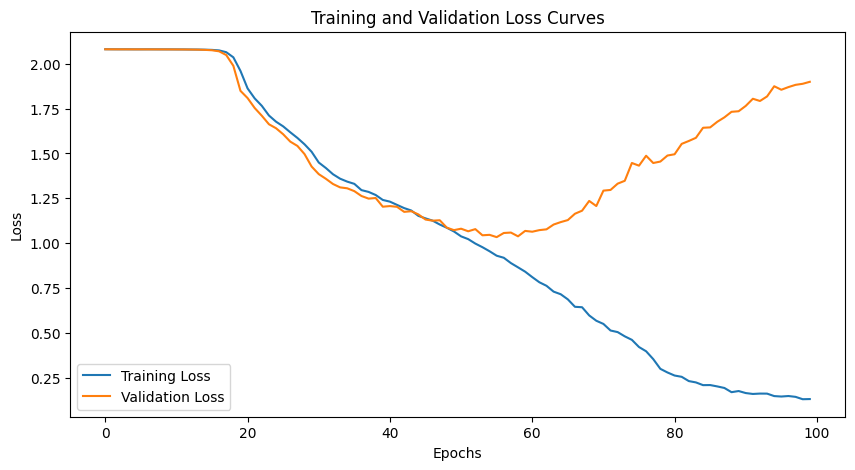

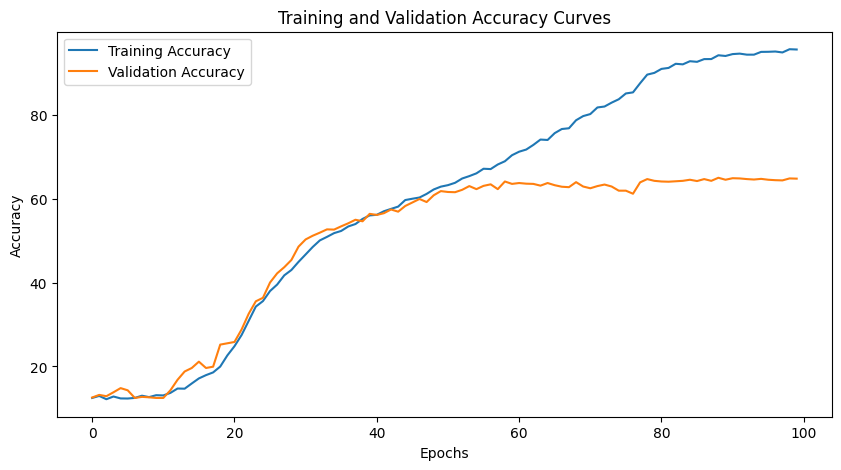

Test Loss: 1.9584
Test Accuracy: 64.32%


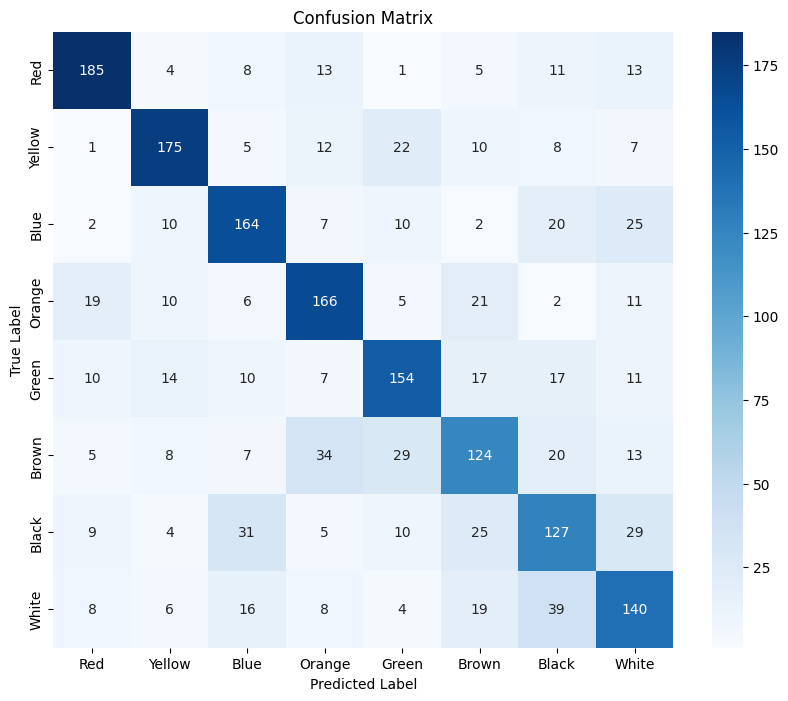

In [45]:
# Performance Metrics

train_losses = logger.logs['train_loss']
val_losses = logger.logs['val_loss']
plot_loss_curves(train_losses, val_losses)

train_accuracies = [acc for acc in logger.logs['train_acc']]
val_accuracies = [acc for acc in logger.logs['val_acc']]
plot_accuracy_curves(train_accuracies, val_accuracies)

y_true = y_test  # Directly use y_test
y_pred = []

with torch.no_grad():
    model.eval()
    for X, y in test_data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

# Print Test Loss and Test Accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_confusion_matrix(y_true, y_pred, labels)

Inference Time Model Profiling

In [46]:
# Evaluate inference time
model.eval()
total_inference_time = 0
total_batches = 0

with torch.no_grad():
    for X, y in tqdm(test_data_loader, unit="batch", desc="Test Inference Time Evaluation"):
        X, y = X.to('cuda'), y.to('cuda')

        start_time = time.time()
        pred = model(X)
        end_time = time.time()

        inference_time = (end_time - start_time) * 1000  # Time in milliseconds
        total_inference_time += inference_time
        total_batches += 1

average_inference_time = total_inference_time / total_batches
print(f"Average Inference Time per Batch: {average_inference_time:.3f} ms")

Test Inference Time Evaluation: 100%|██████████| 60/60 [00:01<00:00, 56.18batch/s]

Average Inference Time per Batch: 1.101 ms


#4 - Final Model Selection

**Model Comparison Chart**

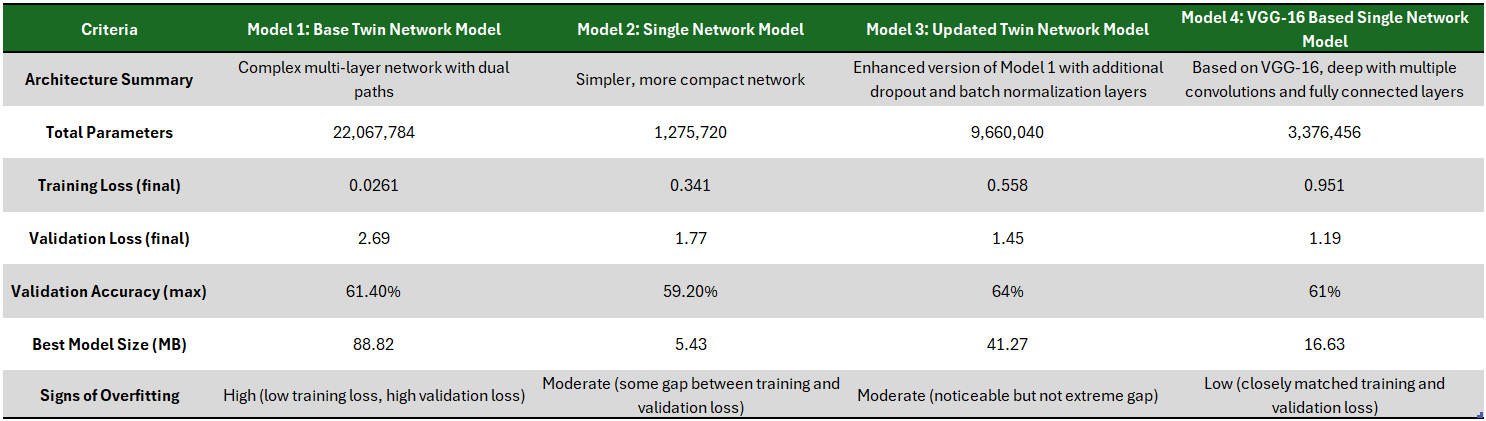

General Observations:
1. Model 3 shows the best validation accuracy and a reasonable balance between training and validation loss, suggesting it might be the most effective model at generalizing from the training data.

2. Model 4, despite its simpler architecture compared to Model 1 and 3, performs competitively in accuracy and has a lower final validation loss, indicating good generalization.

3. Model 1 has an extremely high parameter count which does not translate into significantly better performance, indicating potential overfitting or inefficiency.

4. Model 2 offers the simplest structure with the lowest number of parameters and smallest model size, making it potentially suitable for environments where computational resources are limited, despite its lower accuracy.

**Performance Metrics Analysis**

Training and Validation Loss

1. Model 1 and Model 3 exhibit the classic signs of overfitting, with a low training loss but significantly higher validation loss. This indicates they may be too complex and not generalizing well to unseen data.

2. Model 2 and Model 4 manage a closer gap between training and validation losses, suggesting better generalization. Model 4, in particular, shows an almost parallel trajectory of the training and validation loss, which is ideal.

Accuracy
1. Model 3 shows the highest validation accuracy (64%), which could suggest it's the most effective at the task despite its issues with overfitting.

2. Model 1 and Model 4 also exhibit decent performance with 61% accuracy, but Model 4 is notably less complex which could be a deciding factor in choosing between them.

Complexity vs Performance

1. There's a clear trade-off visible: Model 1 and Model 3 are complex and have high parameter counts but do not significantly outperform the simpler Model 4. Model 2, being the least complex, understandably has the lowest performance but shows efficient use of its simpler architecture.

**Confusion Matrix Analysis**

1. Model 4 and Model 3 exhibit balanced performance across the classes, indicating effective learning, although they still show some confusion between similar color shades.

2. Model 1, despite its complexity, shows notable misclassifications between colors that should be distinguishable, suggesting inefficiencies in how it learns discriminations.

3. Model 2 shows the highest confusion across similar and distinct color classes, reflecting its lower performance metrics.

**Best Model Selection**

Model 3 offers the best balance between high accuracy and reasonable generalization from training to validation. It handles the complexity well enough to achieve the highest accuracy among the models.

#5 - Best Model Results

In [47]:
# Instantiate the model
model = ColorModel3()

# Load the weights
model_weights_path = '/content/models/model3/model3_updated_twin_network/model_60.pt'

# Load the model weights
model.load_state_dict(torch.load(model_weights_path))

# Set the model to evaluation mode
model.eval()

# Check device and send model to device if using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


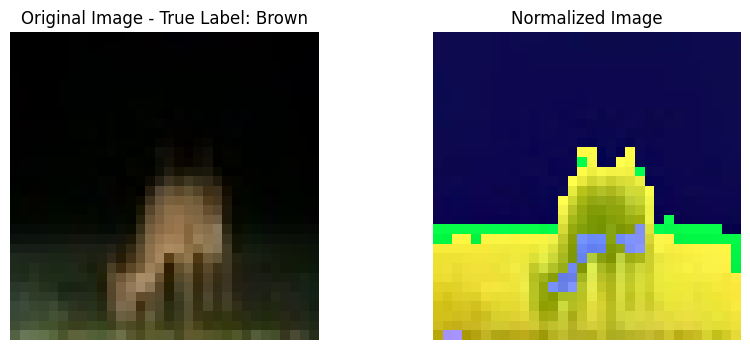

Top 3 Predicted Labels with Confidence Percentages:
1: Label = Brown, Confidence = 88.92%
2: Label = Green, Confidence = 5.09%
3: Label = Black, Confidence = 3.11%


In [52]:
# Set the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a random image and label from the test dataset using the ColorDataset_RGB
random_index = random.randint(0, len(test_dataset_rgb) - 1)
image_normalized, label = test_dataset_rgb[random_index]

# Prepare the image for inference
image_tensor = image_normalized.unsqueeze(0).to(device)  # Add batch dimension and send to device

# Run the model to get the output logits
with torch.no_grad():
    output = model(image_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    top3_prob, top3_labels = torch.topk(probabilities, 3)

# Convert probabilities and labels to CPU for displaying
top3_prob = top3_prob.cpu().numpy().flatten()
top3_labels = top3_labels.cpu().numpy().flatten()

# Visualize the results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Original image (pre normalization)
# Load the image from the file path for visualization
image_path = x_test[random_index]
original_img = np.array(Image.open(image_path).convert('RGB'))
axs[0].imshow(original_img)
axs[0].set_title(f'Original Image - True Label: {labels[label]}')
axs[0].axis('off')

# Normalized image (post normalization)
# Rescale the normalized image for visualization
normalized_img = (original_img - mean_rgb / std_dev_rgb) * 255
normalized_img = normalized_img.astype(np.uint8)
axs[1].imshow(normalized_img)
axs[1].set_title('Normalized Image')
axs[1].axis('off')

plt.show()

# Print the predicted labels with confidence percentages
print("Top 3 Predicted Labels with Confidence Percentages:")
for i, idx in enumerate(top3_labels):
    print(f"{i+1}: Label = {labels[idx]}, Confidence = {top3_prob[i]*100:.2f}%")

#6 - Conclusions

**Insights on Model 1**

1. Training and Validation Loss: The training loss decreases consistently, which is good. However, the validation loss starts increasing after around 20 epochs, suggesting the model begins to overfit the training data around this point.

2. Training and Validation Accuracy: The training accuracy increases and plateaus around 65%, which is relatively low, suggesting the model could benefit from a more complex architecture or better feature extraction. The validation accuracy peaks around 58% and then starts to drop slightly, which also indicates overfitting.

3. Confusion Matrix: The confusion matrix reveals some specific issues with color classification:

* a. The model struggles most with distinguishing between similar color hues such as red, orange, and brown.
* b. Blue, green, and black are often confused with each other.
* c. Yellow has a high rate of misclassification into almost all other colors, indicating possible issues with feature extraction for this color.

**Insights on Model 2**

1. Loss Curves:

The training loss consistently decreases, which indicates that the model is learning effectively from the training data.
The validation loss decreases initially but then starts to increase, suggesting overfitting. The model performs well on training data but is unable to generalize effectively to unseen data after a certain point.

2. Accuracy Curves:

Both training and validation accuracy increase sharply in the initial epochs and then plateau. This is typical in training phases but the plateau at around 60% accuracy suggests limitations in the model's ability to capture the full complexity of the data or possibly issues related to the dataset itself.

3. Confusion Matrix:

The confusion matrix reveals significant misclassifications between similar color classes such as between blue and black, green and brown. This indicates difficulty in distinguishing between colors with close spectral properties or under different lighting conditions.
Some classes like red and yellow appear to be predicted with relatively higher accuracy, but there's still noticeable confusion with other colors.

**Insights on Model 3**

1. Training and Validation Loss:

The training loss shows a consistent decrease, indicating that the model is learning effectively from the training data.
The validation loss starts to plateau and slightly increase after about 20 epochs, suggesting some degree of overfitting where the model's improvements on training data do not generalize as effectively to unseen data.

2. Training and Validation Accuracy:

The training accuracy increases steadily, which is a good sign of the model's capacity to fit the training data.
The validation accuracy also increases but begins to plateau around 60%, indicating potential limitations in the model's ability to generalize beyond the training examples.

3. Confusion Matrix:

The confusion matrix shows significant confusion between certain classes, such as between blue and black, green and brown, which might be due to similar hues or insufficient feature distinction capability of the model.
Colors like red, yellow, and green show relatively better classification accuracy, but there is notable misclassification across colors that share similar shades or lighting conditions.

The proposed updates may not have significantly addressed the underlying issues of model generalization or feature extraction capability.

**Conclusions**

Best Overall Performance

1. Model 3 offers the best balance between high accuracy and reasonable generalization from training to validation. It handles the complexity well enough to achieve the highest accuracy among the models.

Efficiency in Training

1. Model 4 stands out for its efficiency, achieving similar performance metrics to the more complex models but with fewer parameters and less complexity. It also demonstrates the best control over validation loss, indicating stable learning.

Considerations for Improvement

1. Model 1 could benefit from simplification or better regularization to address its overfitting.

2. Model 2 might improve with a more sophisticated architecture or additional layers to enhance its learning capability without significantly increasing complexity.

3. Model 3 and Model 4 could explore adjustments in hyperparameters, such as learning rate or dropout rates, to fine-tune performance and further minimize overfitting.

#7 - References

1. Smits, Thomas & Wevers, Melvin. (2021). The agency of computer vision models as optical instruments. Visual Communication. 21. 147035722199209. 10.1177/1470357221992097.

2. Top 10 Datasets for Computer Vision · Syntric AI. (2022). Retrieved from https://www.syntric.ai/post/unlocking-computer-vision-the-10-best-datasets

3. Common Objects in Context. (n.d.). Retrieved from https://cocodataset.org/#home

4. Meel, V. (2024). What is the COCO Dataset? What you need to know in 2024. Retrieved from https://viso.ai/computer-vision/coco-dataset/

5. Maitlo, N., Noonari, N., Ghanghro, S. A., Duraisamy, S., & Ahmed, F. (2024). Color Recognition in Challenging Lighting Environments: CNN Approach. ArXiv. /abs/2402.04762

6. De, K., & Pedersen, M. (2021). Impact of Colour on Robustness of Deep Neural Networks. 2021 IEEE/CVF International Conference on Computer Vision Workshops (ICCVW), 21–30. https://doi.org/10.1109/ICCVW54120.2021.00009

7. FiftyOne by Voxel 51. (n.d.). Retrieved from https://docs.voxel51.com/

8. COCO Dataset Integration in Fifty One. (n.d.). Retrieved from https://docs.voxel51.com/integrations/coco.html?highlight=coco

9. Hofesmann, E. (2022). The COCO Dataset: Best Practices for Downloading, Visualization, and Evaluation. Retrieved from https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

10. Clustering Images with Embeddings. (n.d.). Retrieved from https://docs.voxel51.com/tutorials/clustering.html

11. Gallagher, J. (2024). Color and Product Type Inspection with Computer Vision. Retrieved from https://blog.roboflow.com/how-to-analyze-product-color/

12. Lin, T.-Y., Maire, M., Belongie, S., Bourdev, L., Girshick, R., Hays, J., … Dollár, P. (2015). Microsoft COCO: Common Objects in Context. Retrieved from https://arxiv.org/abs/1405.0312

13. Rachmadi, R. F., & Purnama, I. K. E. (2018). Vehicle Color Recognition using Convolutional Neural Network. Retrieved from https://arxiv.org/abs/1510.07391

14. Hofesmann, E. (2021). How to work with object detection datasets in COCO format. Retrieved from https://towardsdatascience.com/how-to-work-with-object-detection-datasets-in-coco-format-9bf4fb5848a4

15. Prepare COCO datasets¶. (n.d.). Retrieved from https://cv.gluon.ai/build/examples_datasets/mscoco.html

16. skimage.color#. (n.d.). Retrieved from https://scikit-image.org/docs/dev/api/skimage.color.html

17. Colors Tutorial. W3 Schools. (N.d.). Retrieved from https://www.w3schools.com/colors/colors_wheels.asp#:~:text=The%203%20primary%20colors%20are,Orange%2C%20Green%2C%20and%20Purple.&text=Blue%20and%20Red%20%3D%20Purple.